<h1 style="text-align: center;">Bayesian programming Project</h1>
<p style="text-align: center;">Manuel Acquistapace, Stefano Billeter</p>

Note: Mag/arcsec^2 is a unit used in astronomy to measure the brightness or surface brightness of an object in the sky. It represents the amount of light, or "magnitude," per square arcsecond of the sky. A lower Mag/arcsec^2 value indicates a brighter or more concentrated source of light, while a higher value suggests fainter or more spread-out light. We always express light pollution using this unit, as in the dataset.



In [11]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
import arviz as az

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
file_path = "data.xlsx"
df = pd.read_excel(file_path)

# Descriptive analysis

In [14]:
df.isnull().sum()

timestamp             0
Camignolo            10
Campo vallemaggia    92
Canobbio             50
Carona               32
Chiasso              12
Giubiasco            12
Gnosca               25
Locarno              45
Msio                 29
M.Lema               43
Monteggio            18
Lucomagno            95
Bodio                 0
dtype: int64

From the series of numbers above, we can see that there is a variable number of missing values for each location, meaning that we cannot retain the tabular form of the data, since imputing the observations with artificially generated values would compromise our observed data.

In [15]:
df.dtypes

timestamp            datetime64[ns]
Camignolo                   float64
Campo vallemaggia           float64
Canobbio                    float64
Carona                      float64
Chiasso                     float64
Giubiasco                   float64
Gnosca                      float64
Locarno                     float64
Msio                        float64
M.Lema                      float64
Monteggio                   float64
Lucomagno                   float64
Bodio                       float64
dtype: object

In [16]:
df

timestamp  Camignolo  Campo vallemaggia  Canobbio  Carona  \
0   2022-01-01 12:00:00       20.8               21.6      19.9    20.7   
1   2022-01-02 12:00:00       20.8               21.7      19.9    20.6   
2   2022-01-03 12:00:00       20.7               21.6      19.8    20.6   
3   2022-01-04 12:00:00       18.9                NaN      17.1    18.2   
4   2022-01-05 12:00:00       20.6               21.5      19.7    20.4   
..                  ...        ...                ...       ...     ...   
694 2023-11-26 12:00:00       20.1               20.3      19.4    19.9   
695 2023-11-27 12:00:00       19.2               19.3      18.7    19.1   
696 2023-11-28 12:00:00       19.5               19.7      18.9    19.4   
697 2023-11-29 12:00:00       19.8               20.4      18.9    19.3   
698 2023-11-30 12:00:00       17.6               19.9      16.8    19.6   

     Chiasso  Giubiasco  Gnosca  Locarno  Msio  M.Lema  Monteggio  Lucomagno  \
0       19.5       20.2    21.1     20.8  19.8    20.6       20.9       22.0   
1       19.4       20.2    21.0     20.8  19.7    20.6       20.9       22.1   
2       19.3       20.0    20.9     20.8  19.6    20.6       20.8       21.9   
3       17.3       19.3    20.3     19.9  17.1    20.1       19.2       22.2   
4       19.4       19.9    20.9     20.5  19.6    20.6       20.7        NaN   
..       ...        ...     ...      ...   ...     ...        ...        ...   
694     19.2       19.9    20.1     20.0  19.6    19.8       20.0       20.7   
695     18.4       19.0    19.1     19.3  18.8    19.0       18.8       19.6   
696     18.7       19.0    19.6     19.6  19.1    19.3       19.7       21.0   
697     18.5       19.2    20.0     19.9  18.7    19.6       19.8       21.0   
698     16.7       17.4    18.2     17.5  18.1    20.0       19.6       21.8   

     Bodio  
0     20.6  
1     20.5  
2     20.3  
3     20.3  
4     20.5  
..     ...  
694   19.6  
695   19.1  
696   19.5  
697   19.7  
698   19.0  

[699 rows x 14 columns]

In [17]:
type(df.loc[3, "Campo vallemaggia"])

numpy.float64

##### Missing values

In [18]:
df.isnull().sum()

timestamp             0
Camignolo            10
Campo vallemaggia    92
Canobbio             50
Carona               32
Chiasso              12
Giubiasco            12
Gnosca               25
Locarno              45
Msio                 29
M.Lema               43
Monteggio            18
Lucomagno            95
Bodio                 0
dtype: int64

In [19]:
df_gr = df.copy()
df_gr["period"] = df["timestamp"].apply(lambda x: (x.month // 2) - 1 if x.month % 2 == 0 else (x.month - 1) // 2)
df_gr["year"] = df["timestamp"].dt.year

In [20]:
df_gr.dtypes

timestamp            datetime64[ns]
Camignolo                   float64
Campo vallemaggia           float64
Canobbio                    float64
Carona                      float64
Chiasso                     float64
Giubiasco                   float64
Gnosca                      float64
Locarno                     float64
Msio                        float64
M.Lema                      float64
Monteggio                   float64
Lucomagno                   float64
Bodio                       float64
period                        int64
year                          int64
dtype: object

In [21]:
freqs = df_gr.reset_index().loc[:, ["period", "year", "timestamp"]].groupby(["year", "period"]).count()
freqs.head()

timestamp
year period           
2022 0              59
     1              61
     2              61
     3              62
     4              61

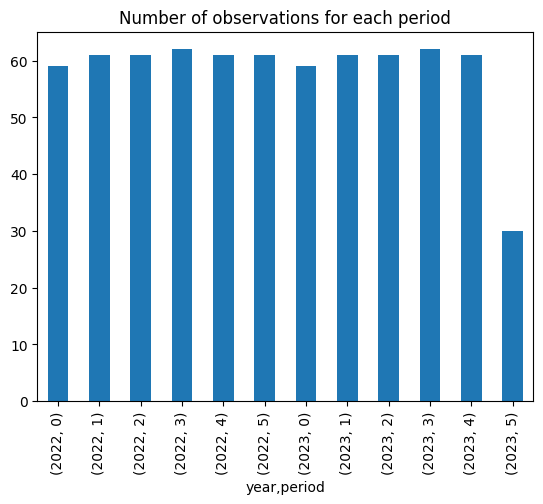

In [22]:
freqs.plot.bar(legend=False)
plt.title("Number of observations for each period");

For our project, we are considering data grouped by periods (averaging all observations belonging to each of them). In particular, we considered timesteps on a bi-monthly basis.

In [23]:
df_gr = df_gr.groupby(by=["year", "period"]).mean(numeric_only=False).drop(["timestamp"], axis=1)

In [24]:
df_gr.head()

Camignolo  Campo vallemaggia   Canobbio     Carona    Chiasso  \
year period                                                                  
2022 0       20.333898          21.136585  19.383051  20.266102  19.076271   
     1       19.983333          21.080000  18.953333  19.834426  18.788333   
     2       20.242623          21.483607  19.266667  20.047541  19.026230   
     3       20.438710          21.300000  19.489796  20.265574  19.259677   
     4       20.226230          21.336364  19.235556  20.026923  19.024590   

             Giubiasco     Gnosca    Locarno       Msio     M.Lema  Monteggio  \
year period                                                                     
2022 0       19.730508  20.581034  20.323077  19.277193  20.427119  20.484746   
     1       19.393333  20.298361  19.914754  18.917391  20.239344  20.163333   
     2       19.701639  20.886885  20.195082  19.214754  20.354098  20.332787   
     3       19.804839  21.196667  20.359677  19.466102  20.412903  20.454839   
     4       19.576271  20.570492  20.050000  19.236066  20.271154  20.308197   

             Lucomagno      Bodio  
year period                        
2022 0       21.832143  20.226114  
     1       21.857407  19.778103  
     2       21.781818  20.098361  
     3       21.925424  20.254839  
     4       21.812500  20.142623

We will now manage the missing values converting the tabular format (pd.DataFrame) into plain Python dictionaries.

In [25]:
data = df.drop(["timestamp"], axis=1).to_dict(orient="list")
data_gr = df_gr.reset_index([0, 1]).drop(["period", "year"], axis=1).to_dict(orient="list")

for k in data:
    data[k] = list(filter(lambda x: not math.isnan(x), data[k]))
    data_gr[k] = list(filter(lambda x:  not math.isnan(x), data_gr[k]))

In [26]:
for k in data:
    print(f"{k} has {len(data[k])} daily obsevations")

Camignolo has 689 daily obsevations
Campo vallemaggia has 607 daily obsevations
Canobbio has 649 daily obsevations
Carona has 667 daily obsevations
Chiasso has 687 daily obsevations
Giubiasco has 687 daily obsevations
Gnosca has 674 daily obsevations
Locarno has 654 daily obsevations
Msio has 670 daily obsevations
M.Lema has 656 daily obsevations
Monteggio has 681 daily obsevations
Lucomagno has 604 daily obsevations
Bodio has 699 daily obsevations


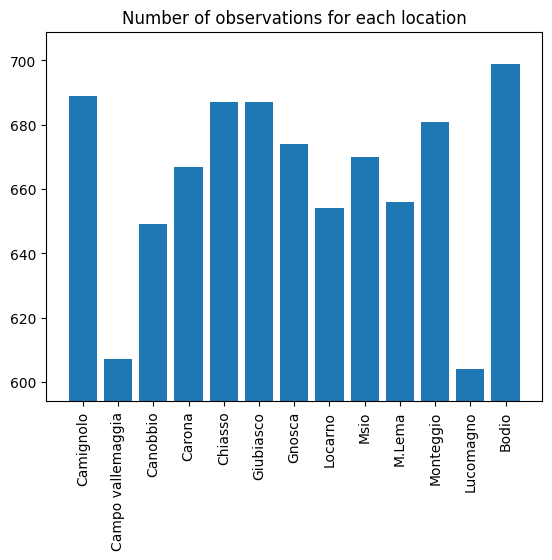

In [27]:
n_obs = [len(x) for x in data.values()]
plt.bar(x=list(data.keys()), height=n_obs)
k = 10
plt.ylim([min(n_obs) - k, max(n_obs) + k])
plt.xticks(rotation=90)
plt.title("Number of observations for each location");

As we can see from the plot above, Campo vallemaggia and Lucomagno are the locatioins with the fewest observations, but still there is a reasonable difference (95 observations) between the number of records of the most frequent location (Bodio) and the least (Lucomagno).

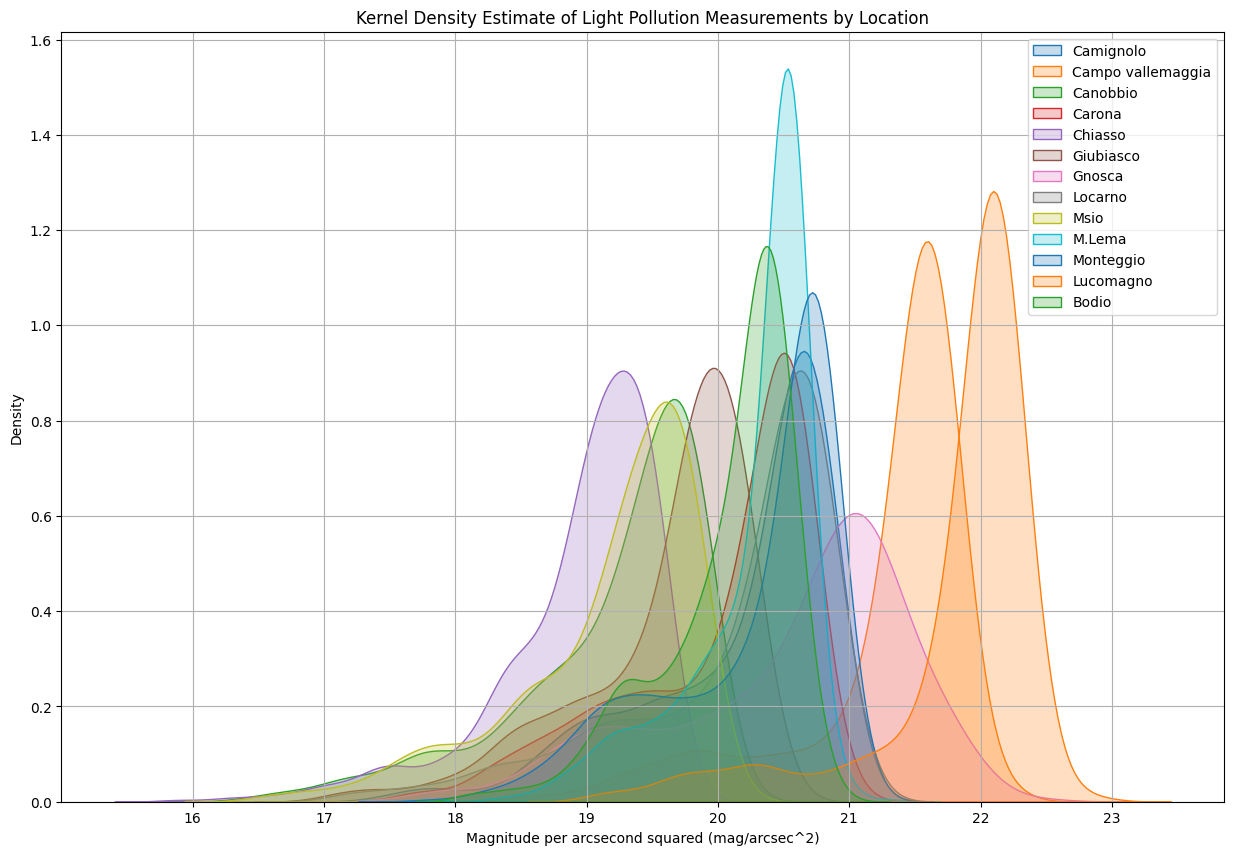

In [28]:
data_without_timestamp = df.drop(columns=['timestamp'])
plt.figure(figsize=(15, 10))
for column in data_without_timestamp.columns:
    sns.kdeplot(data_without_timestamp[column], label=column, fill=True)

plt.title('Kernel Density Estimate of Light Pollution Measurements by Location')
plt.xlabel('Magnitude per arcsecond squared (mag/arcsec^2)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

From the KDEs above, we can derive that all distributions resemble a Gaussian distribution, but carry a significant number of outliers. Hence, the choice of the T-Student distribution during our project for modeling the data.

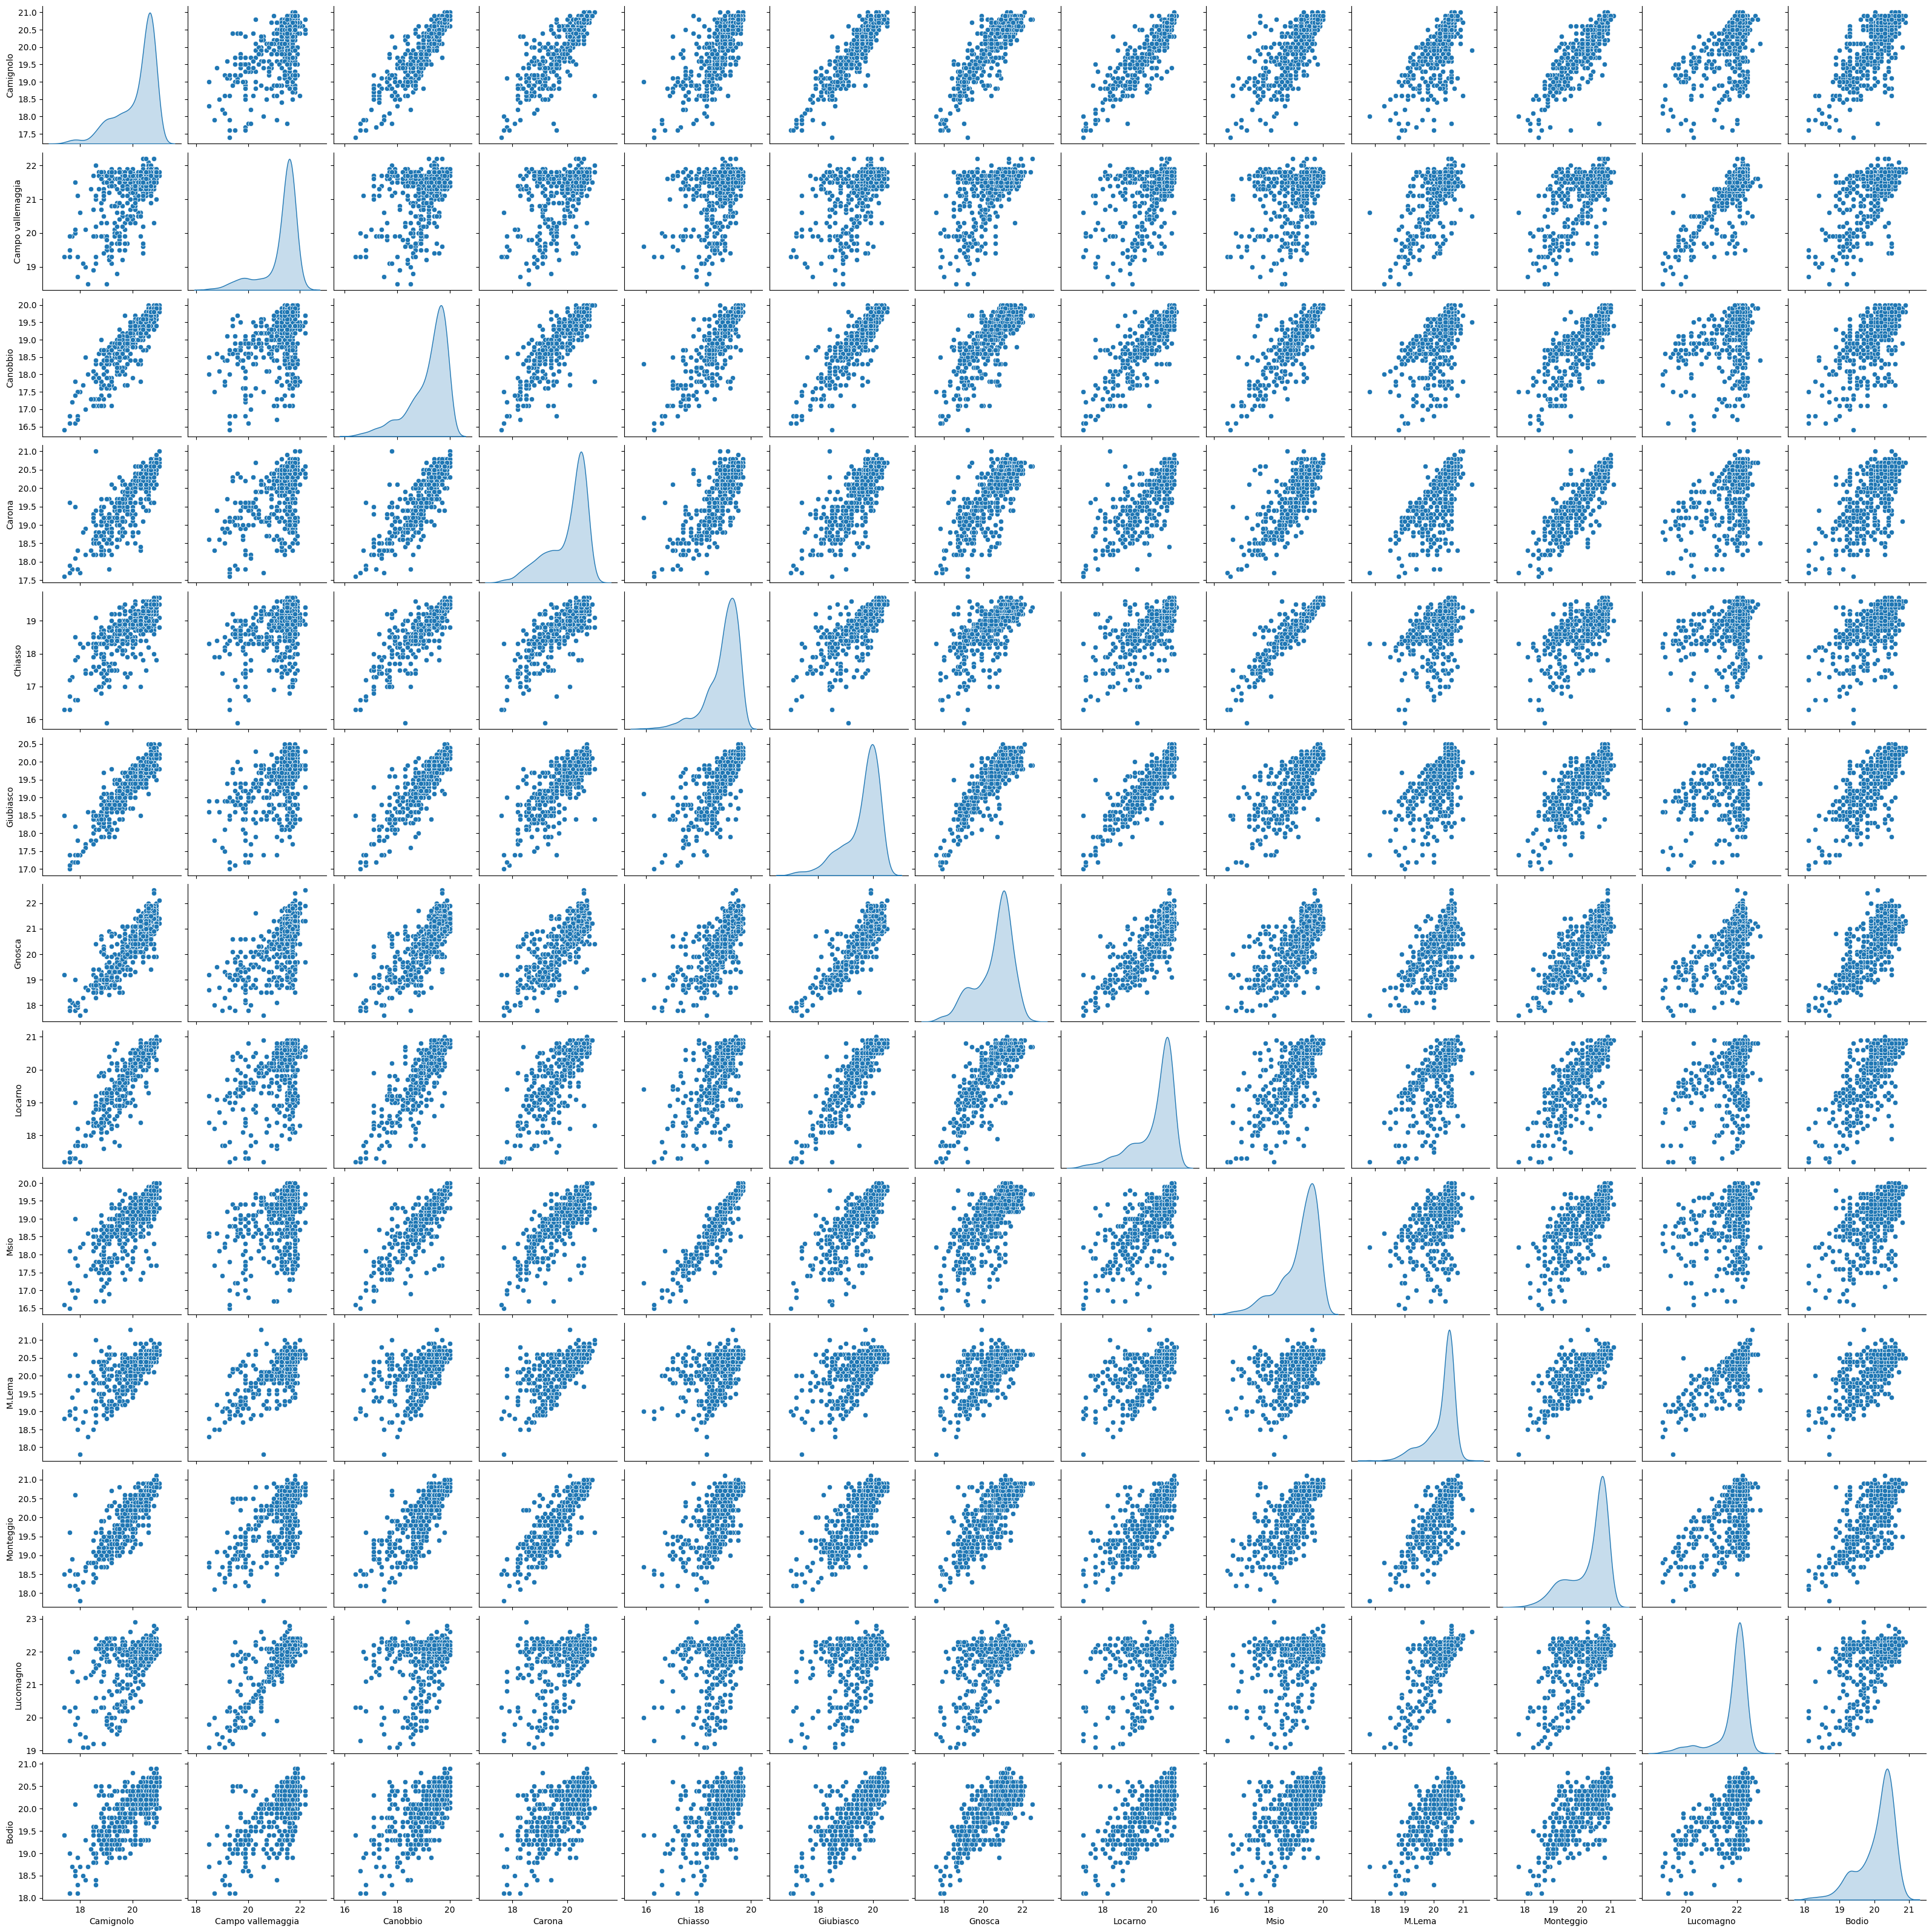

In [29]:
data_without_timestamp = df.drop(columns=['timestamp'])
sns.pairplot(data_without_timestamp, diag_kind="kde");

In [30]:
df.describe()

Camignolo  Campo vallemaggia    Canobbio      Carona   Chiasso  \
count  689.000000         607.000000  649.000000  667.000000  687.0000   
mean    20.167925          21.273311   19.191680   20.014693   18.9377   
std      0.728331           0.681809    0.723647    0.711590    0.6119   
min     17.400000          18.500000   16.400000   17.600000   15.9000   
25%     19.800000          21.200000   18.900000   19.600000   18.7000   
50%     20.500000          21.500000   19.400000   20.300000   19.1000   
75%     20.700000          21.700000   19.700000   20.600000   19.4000   
max     21.000000          22.200000   20.000000   21.000000   19.7000   

        Giubiasco      Gnosca     Locarno        Msio      M.Lema   Monteggio  \
count  687.000000  674.000000  654.000000  670.000000  656.000000  681.000000   
mean    19.598108   20.565430   20.119878   19.159104   20.262195   20.258150   
std      0.658658    0.914035    0.809422    0.689012    0.484606    0.666705   
min     17.000000   17.600000   17.200000   16.500000   17.800000   17.800000   
25%     19.300000   20.000000   19.800000   18.825000   20.100000   19.800000   
50%     19.800000   20.800000   20.500000   19.400000   20.500000   20.600000   
75%     20.100000   21.200000   20.700000   19.700000   20.600000   20.800000   
max     20.500000   22.500000   21.000000   20.000000   21.300000   21.100000   

        Lucomagno       Bodio  
count  604.000000  699.000000  
mean    21.820033   20.075742  
std      0.659976    0.504132  
min     19.100000   18.100000  
25%     21.800000   19.800000  
50%     22.000000   20.300000  
75%     22.200000   20.400000  
max     22.900000   20.900000

# Hypothesis testing

### 1. Comparing mean light pollution between Chiasso and Monteggio
$$ H_0: \mu_{Chiasso} - \mu_{Monteggio} = 0 $$
$$ H_1: \mu_{Chiasso} - \mu_{Monteggio} \neq 0 $$


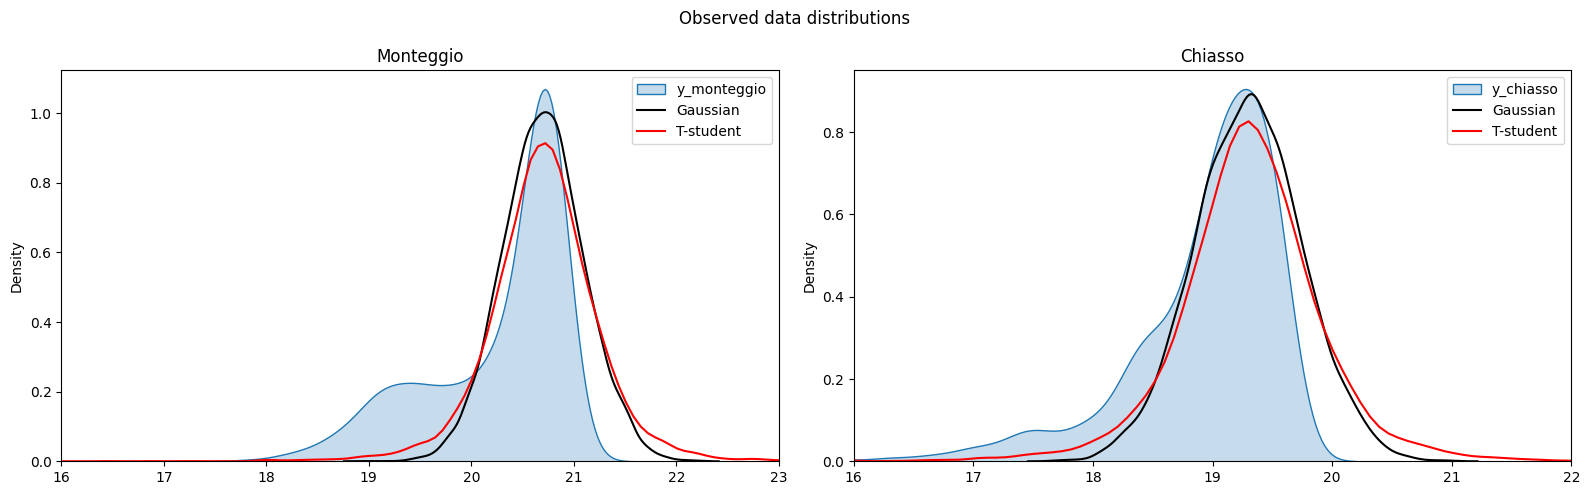

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
for i, loc in enumerate(("Monteggio", "Chiasso")):
    sns.kdeplot(data[loc], fill=True, ax=axs[i], label=f"y_{loc.lower()}")

sns.kdeplot(stats.norm.rvs(size=10000, loc=20.7, scale=0.4), ax=axs[0], color="black", label="Gaussian")
sns.kdeplot(stats.t.rvs(df=4, size=10000, loc=20.7, scale=0.4), ax=axs[0], color="red", label="T-student")

sns.kdeplot(stats.norm.rvs(size=10000, loc=19.3, scale=0.45), ax=axs[1], color="black", label="Gaussian")
sns.kdeplot(stats.t.rvs(df=4, size=10000, loc=19.3, scale=0.45), ax=axs[1], color="red", label="T-student")


for i in range(2):
    axs[i].legend()

axs[0].set_title("Monteggio")
axs[1].set_title("Chiasso")
axs[0].set_xlim(16, 23)
axs[1].set_xlim(16, 22)

fig.suptitle("Observed data distributions")
plt.tight_layout()

Once again, we opted for the T-Student distribution because it is more permissive, meaning that it allows values far from the distribution expected value, so that it takes into account the presence of the outliers.

Searching on the internet, we arrived to the prior that the mean light pollution around Ticino is 20 mag/arcsec^2, with an uncertainty of ±1 (19 Chiasso, 21 Lucomagno).
Based on insights found online, the values of light pollution go from 15 to 23 mag/arcsec^2. \
Consequently, we set the standard devation priors so that:
* The HalfNormal median is around 2 ((23 - 15) / 4)
* The Guassian mean is 20, with a standard deviation of 0.5 (2 / 4)

All the information concerning the mean has been derived from the following website: https://www.lightpollutionmap.info

In [32]:
pd.DataFrame(stats.halfnorm.rvs(size=1000, scale=3)).describe()

0
count  1000.000000
mean      2.347990
std       1.818855
min       0.007047
25%       0.919942
50%       1.934275
75%       3.403838
max      10.510107

In [33]:
with pm.Model() as model:

    mean_chiasso = pm.Normal('mean_chiasso', mu=20, sigma=0.5)
    mean_monteggio = pm.Normal('mean_monteggio', mu=20, sigma=0.5)
    std_chiasso = pm.HalfNormal('std_chiasso', sigma=3)
    std_monteggio = pm.HalfNormal('std_monteggio', sigma=3)

    likelihood_chiasso = pm.StudentT('likelihood_chiasso', nu=4, mu=mean_chiasso, sigma=std_chiasso, observed=data['Chiasso'])
    likelihood_monteggio = pm.StudentT('likelihood_monteggio', nu=4, mu=mean_monteggio, sigma=std_monteggio, observed=data['Monteggio'])
    delta_means = pm.Deterministic('delta_means', mean_chiasso - mean_monteggio)

    trace_ht_1 = pm.sample()

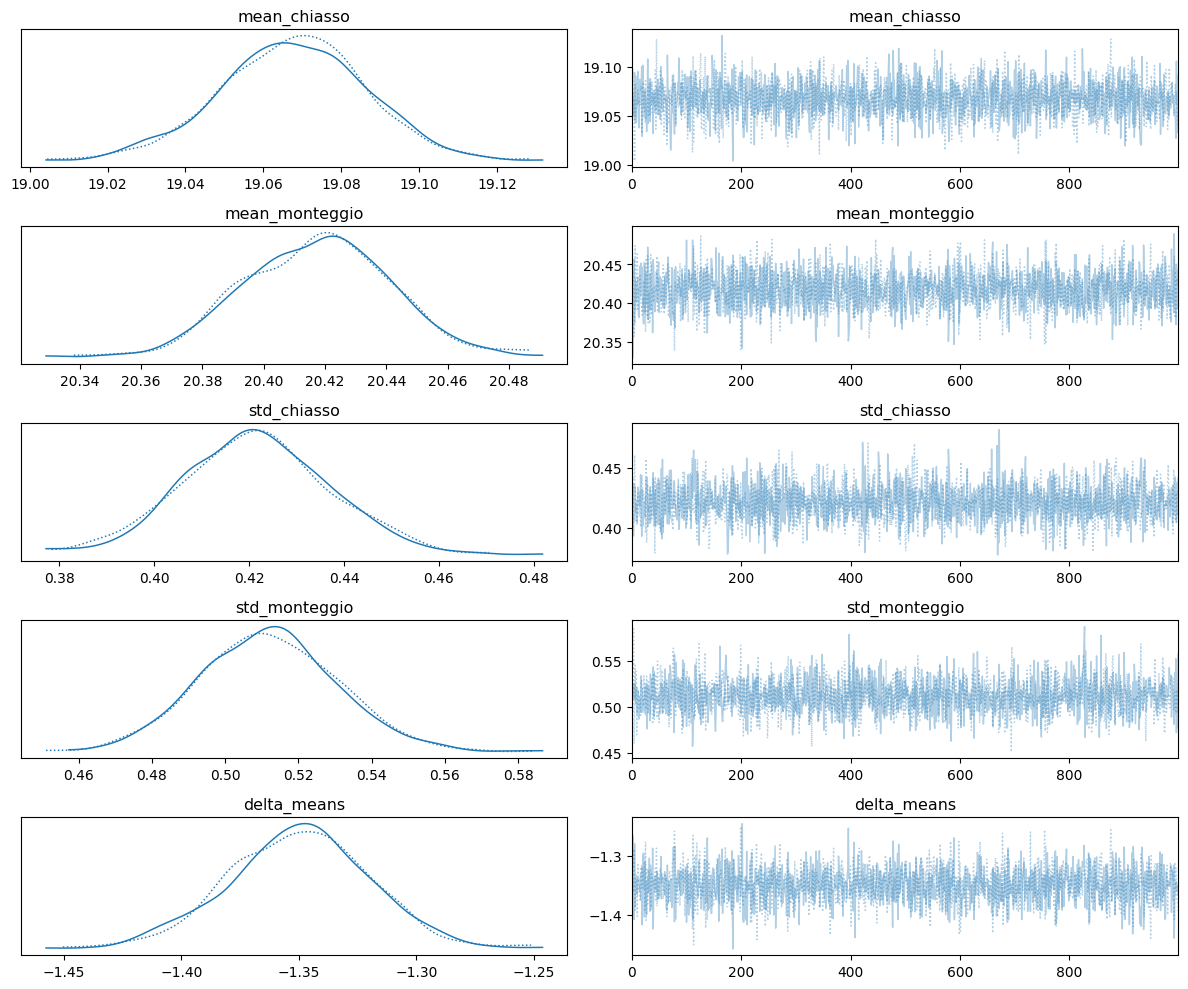

In [34]:
az.plot_trace(trace_ht_1)
plt.tight_layout()

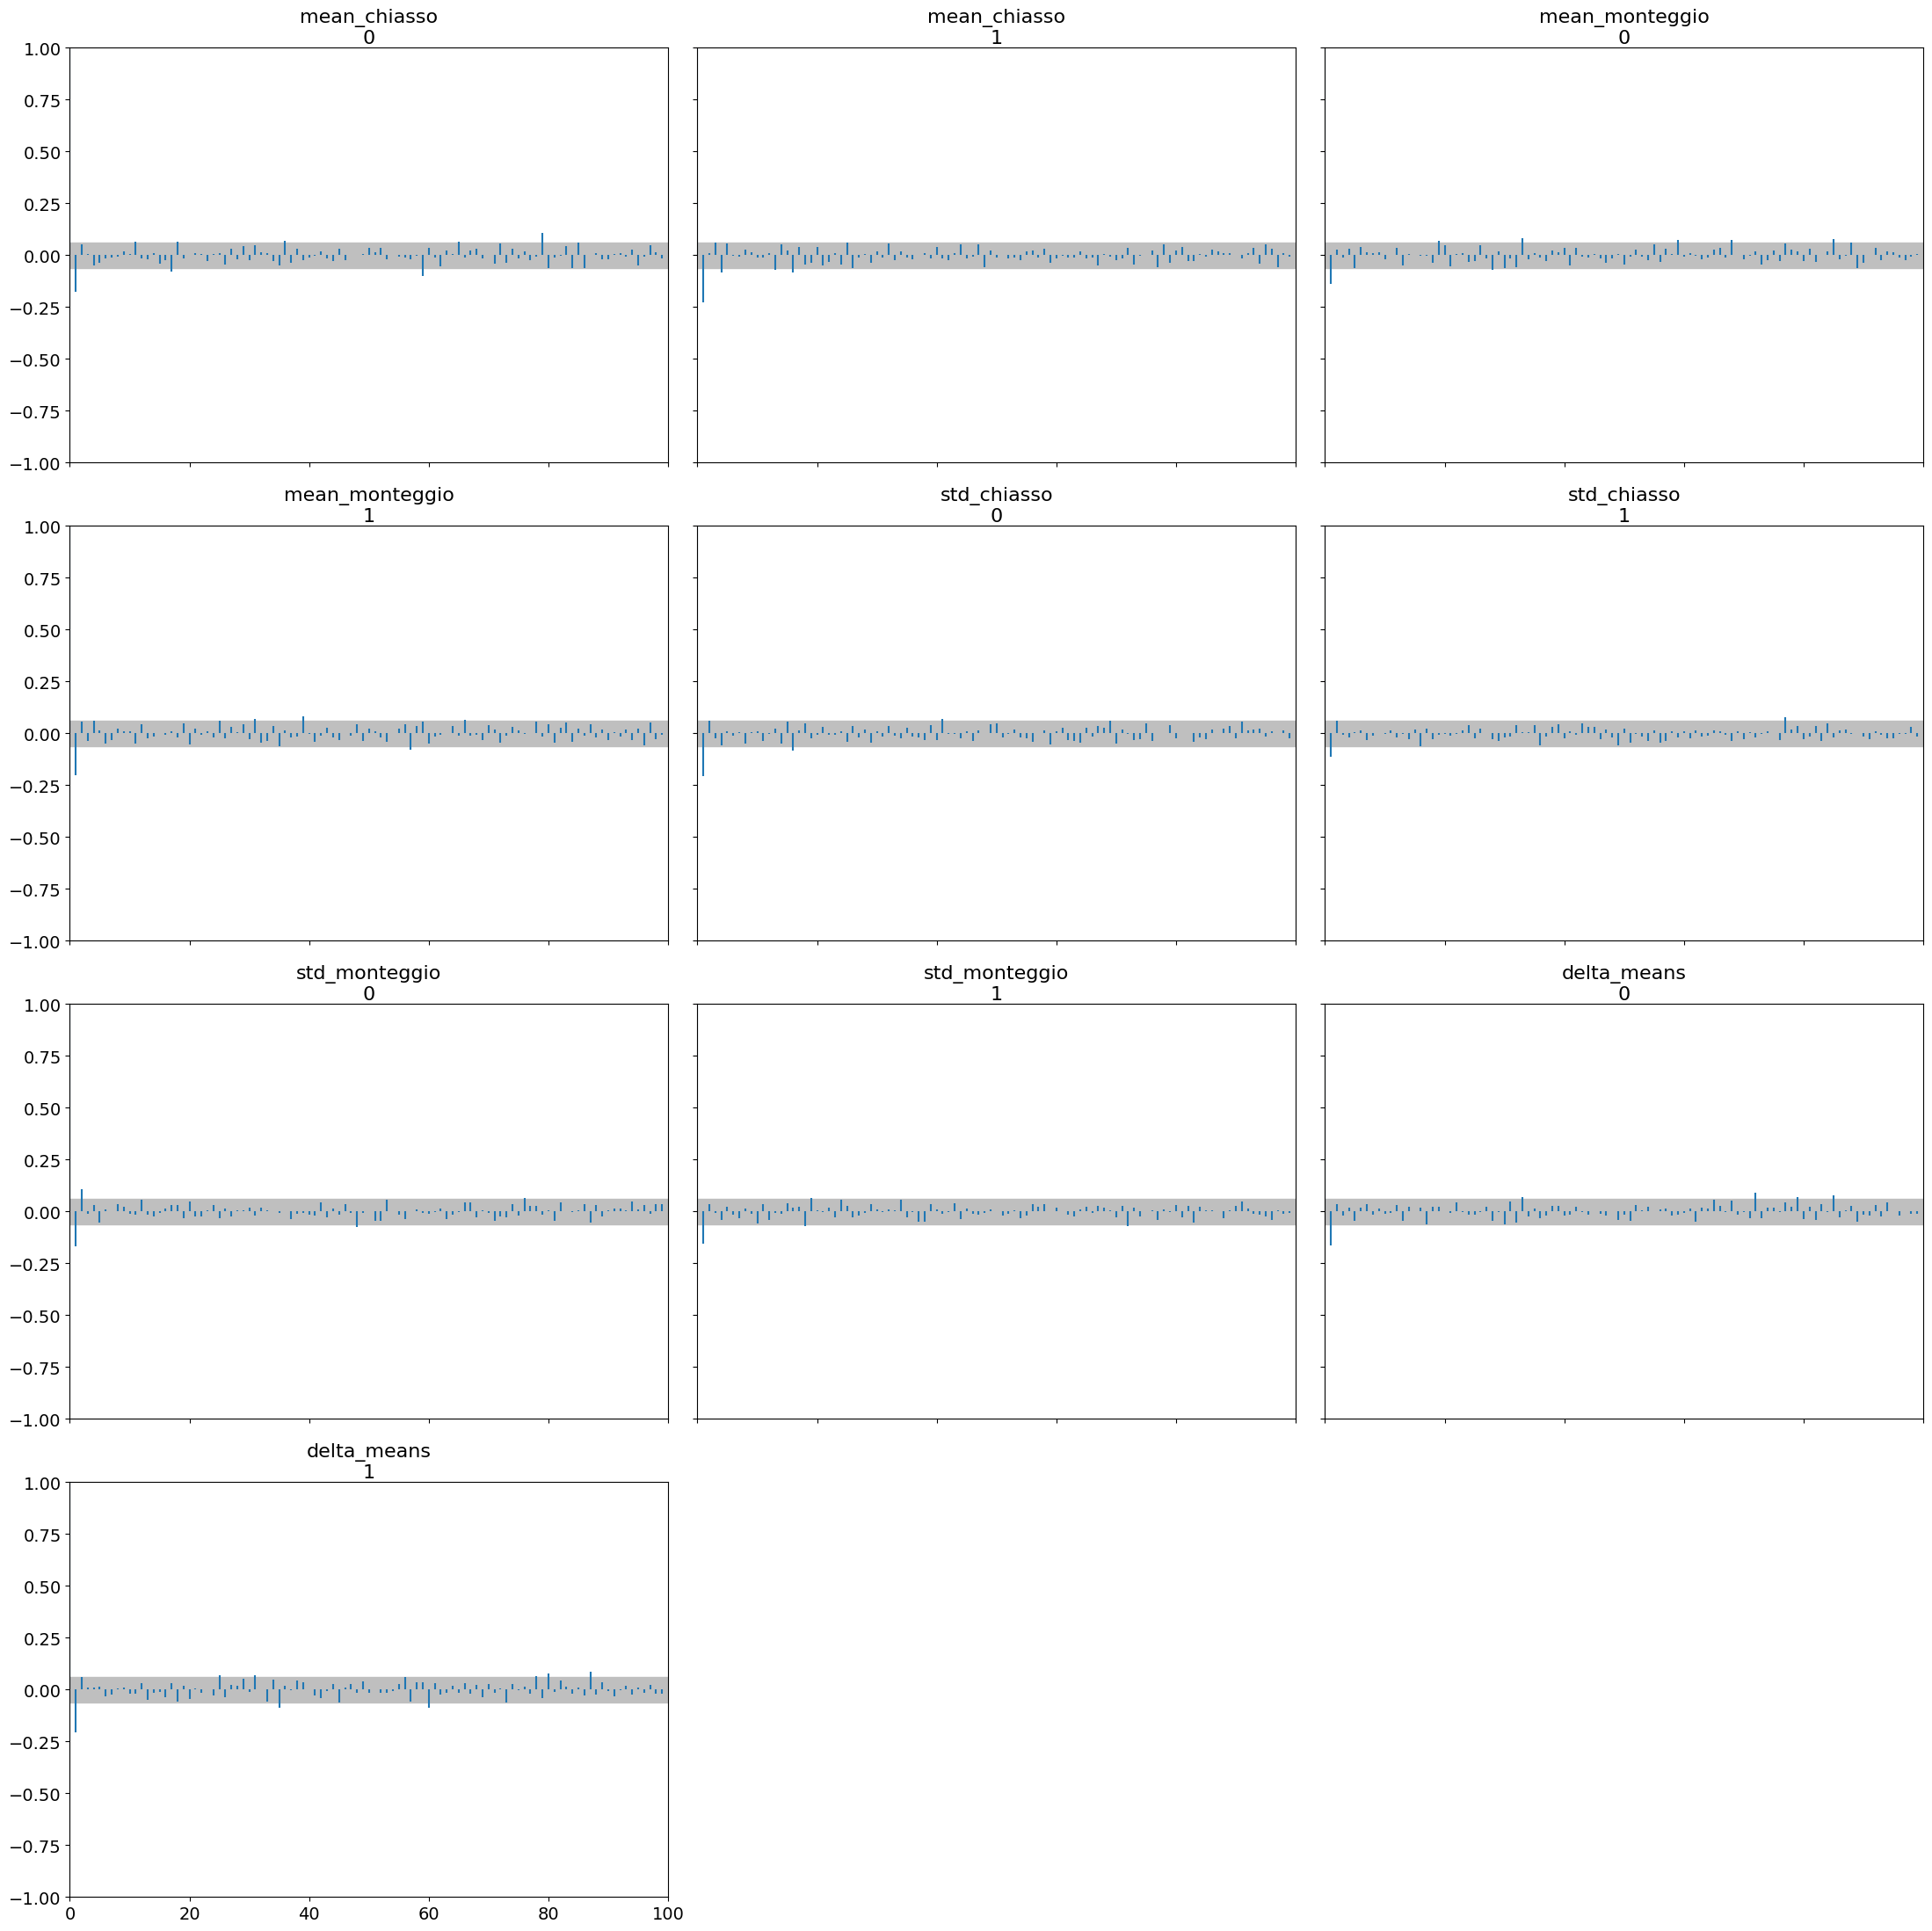

In [35]:
az.plot_autocorr(trace_ht_1)
plt.tight_layout();

The convergence of the sampling went well, as the trace plot resambles white noise, the distributions of the traces of different chains overlap almost completely and the autocorrelation plot shows small correlations for values with lag 2 and above.

In [36]:
az.summary(trace_ht_1)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mean_chiasso    19.068  0.019  19.030   19.101      0.000      0.0    2802.0   
mean_monteggio  20.417  0.024  20.373   20.461      0.000      0.0    2832.0   
std_chiasso      0.421  0.015   0.392    0.450      0.000      0.0    2652.0   
std_monteggio    0.512  0.019   0.476    0.546      0.000      0.0    2570.0   
delta_means     -1.350  0.030  -1.408   -1.295      0.001      0.0    2788.0   

                ess_tail  r_hat  
mean_chiasso      1784.0    1.0  
mean_monteggio    1660.0    1.0  
std_chiasso       1637.0    1.0  
std_monteggio     1567.0    1.0  
delta_means       1534.0    1.0

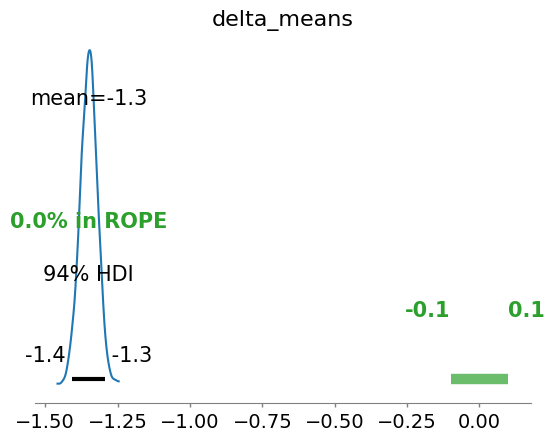

In [37]:
az.plot_posterior(trace_ht_1, var_names=["delta_means"], rope=(-0.1, 0.1));

The conclusions here are that we are very confident that, in light of the data seen, the mean of light pollution of Monteggio is higher compared to the one of Chiasso.
That means that, in average, Chiasso is more polluted compared to Moteggio, as expected.

#### Posterior predictive checks

In [38]:
mean_chiasso_vals, mean_monteggio_vals, std_chiasso_vals, std_monteggio_vals = (
    az.extract(trace_ht_1).mean_chiasso.values,
    az.extract(trace_ht_1).mean_monteggio.values,
    az.extract(trace_ht_1).std_chiasso.values,
    az.extract(trace_ht_1).std_monteggio.values
)

In [39]:
def get_posterior_predictive_checks(mean_vals, std_vals, size, n_checks=20):
    checks = []
    for j in np.random.randint(0, len(mean_vals) - 1, size=n_checks):
        distribution_sampled = stats.t.rvs(size=size, df=4, loc=mean_vals[j], scale=std_vals[j])
        checks.append(distribution_sampled)

    return checks

In [40]:
checks_chiasso = get_posterior_predictive_checks(mean_chiasso_vals, std_chiasso_vals, size=len(data["Chiasso"]), n_checks=100)
checks_monteggio = get_posterior_predictive_checks(mean_monteggio_vals, std_monteggio_vals, size=len(data["Monteggio"]), n_checks=100)

pd.concat([
    pd.DataFrame(checks_chiasso[0], columns=["Checks Chiasso"]),
    pd.DataFrame(checks_monteggio[0], columns=["Checks Monteggio"])
], axis=1)

Checks Chiasso  Checks Monteggio
0         18.465419         20.663438
1         19.434761         20.275208
2         18.797510         20.016378
3         18.836798         20.668622
4         20.948710         18.088680
..              ...               ...
682       19.489917               NaN
683       19.415499               NaN
684       19.656298               NaN
685       19.753771               NaN
686       18.836012               NaN

[687 rows x 2 columns]

The last observations are missing values since the data for Monteggio is fewer compared to the data for Chiasso.

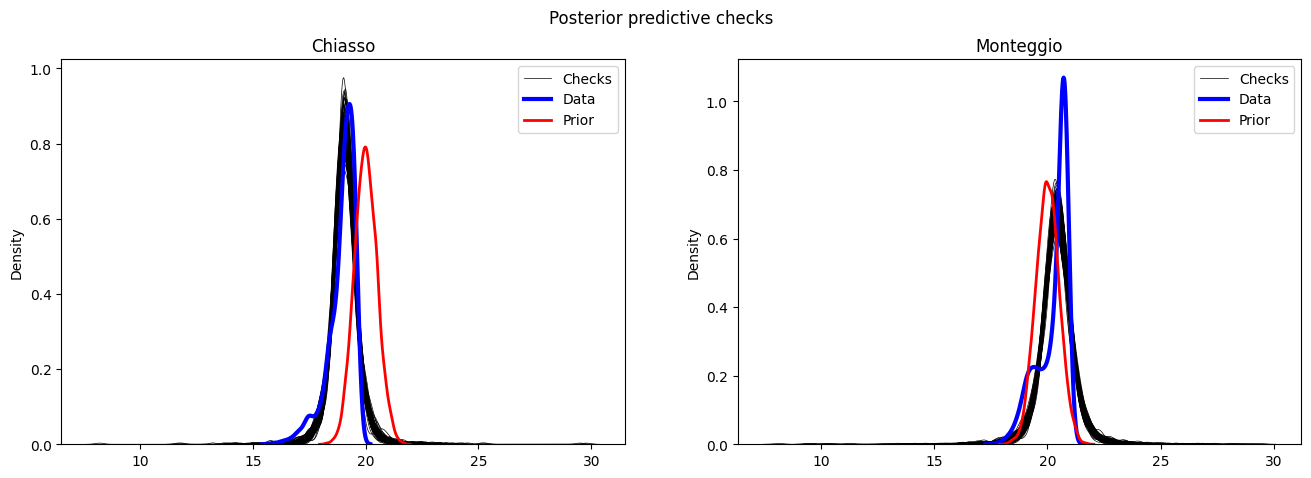

In [41]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
for i, check in enumerate(checks_chiasso):
    if i == 0:
        sns.kdeplot(check, ax=axs[0], linewidth=0.5, color="black", label="Checks")
        continue

    sns.kdeplot(check, ax=axs[0], linewidth=0.5, color="black")

for i, check in enumerate(checks_monteggio):
    if i == 0:
        sns.kdeplot(check, ax=axs[1], linewidth=0.5, color="black", label="Checks")
        continue

    sns.kdeplot(check, ax=axs[1], linewidth=0.5, color="black")

axs[0].set_title("Chiasso")
axs[1].set_title("Monteggio")
fig.suptitle("Posterior predictive checks")

sns.kdeplot(data["Chiasso"], ax=axs[0], linewidth=3, color="b", label="Data")
sns.kdeplot(data["Monteggio"], ax=axs[1], linewidth=3, color="b", label="Data")

sns.kdeplot(stats.norm.rvs(size=5000, loc=20, scale=0.5), ax=axs[0], linewidth=2, color="r", label="Prior")
sns.kdeplot(stats.norm.rvs(size=5000, loc=20, scale=0.5), ax=axs[1], linewidth=2, color="r", label="Prior")

axs[0].legend()
axs[1].legend();

As expected, taking 100 combinations of parameters from the trace, we clearly see that they reshape the observed data quite well.
* For Chiasso the data contained few ouliers and, given the presence of a high number of observations, the posterior will highly follow the data.
* For Monteggio there are more outliers on the left-hand side of the distribution, therefore the t-distribution will be slightly shifted to the left compared to the observed data mean.

#### Prior sensitivity

In [42]:
with pm.Model() as model_sensitivity:
    # Weaker priors, shifted prior mean
    mean_chiasso_sens = pm.Normal('mean_chiasso', mu=22, sigma=1.5)
    mean_monteggio_sens = pm.Normal('mean_monteggio', mu=22, sigma=1.5)
    std_chiasso_sens = pm.HalfNormal('std_chiasso', sigma=4)
    std_monteggio_sens = pm.HalfNormal('std_monteggio', sigma=4)

    likelihood_chiasso_sens = pm.StudentT('likelihood_chiasso', nu=4, mu=mean_chiasso_sens, sigma=std_chiasso_sens, observed=data['Chiasso'])
    likelihood_monteggio_sens = pm.StudentT('likelihood_monteggio', nu=4, mu=mean_monteggio_sens, sigma=std_monteggio_sens, observed=data['Monteggio'])

    delta_means_sens = pm.Deterministic('delta_means', mean_chiasso_sens - mean_monteggio_sens)

    trace_sensitivity_1 = pm.sample()

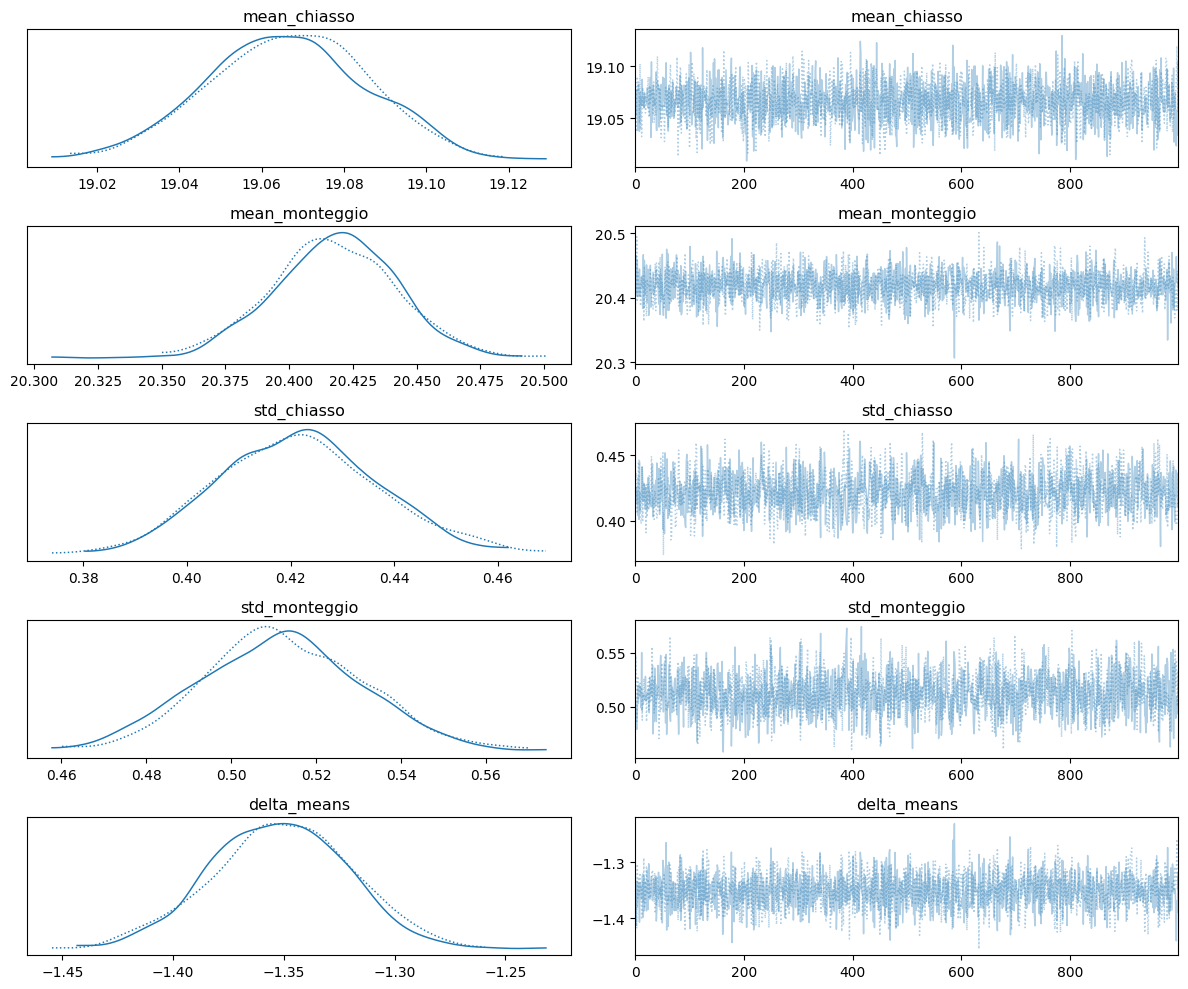

In [43]:
az.plot_trace(trace_sensitivity_1)
plt.tight_layout()

In [44]:
az.summary(trace_sensitivity_1)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mean_chiasso    19.066  0.019  19.031   19.103      0.000      0.0    2916.0   
mean_monteggio  20.418  0.024  20.370   20.460      0.000      0.0    2760.0   
std_chiasso      0.422  0.015   0.393    0.450      0.000      0.0    1634.0   
std_monteggio    0.512  0.019   0.476    0.548      0.000      0.0    1903.0   
delta_means     -1.352  0.031  -1.412   -1.296      0.001      0.0    2957.0   

                ess_tail  r_hat  
mean_chiasso      1866.0    1.0  
mean_monteggio    2046.0    1.0  
std_chiasso       1594.0    1.0  
std_monteggio     1779.0    1.0  
delta_means       1472.0    1.0

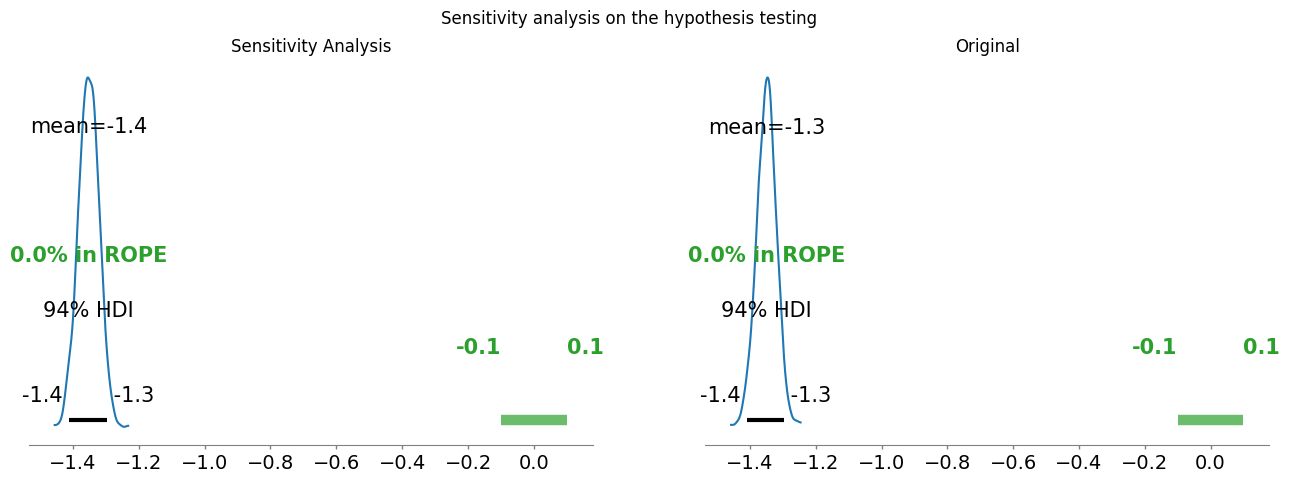

In [45]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
az.plot_posterior(trace_sensitivity_1, var_names=["delta_means"], rope=(-0.1, 0.1), ax=axs[0])
az.plot_posterior(trace_ht_1, var_names=["delta_means"], rope=(-0.1, 0.1), ax=axs[1])

axs[0].set_title("Sensitivity Analysis")
axs[1].set_title("Original")

fig.suptitle("Sensitivity analysis on the hypothesis testing");

Even with a weaker prior (and shifted), the results obtained for the posterior distribution of the difference of means remain the same.

### 2. In Carona, the mean luminescence in 2023 is lower than the mean in 2022

$$ H_0: \mu_{2023} - \mu_{2022} \geq 0 $$
$$ H_1: \mu_{2023} - \mu_{2022} \lt 0 $$

In [46]:
carona_2022 = df.loc[df["timestamp"].dt.year == 2022, "Carona"]
carona_2023 = df.loc[df["timestamp"].dt.year == 2023, "Carona"]

In [47]:
len(carona_2022), len(carona_2023)

(365, 334)

In [48]:
carona_2022 = [x for x in carona_2022.values if not math.isnan(x)]
carona_2023 = [x for x in carona_2023.values if not math.isnan(x)]

Considering just defined values

In [49]:
len(carona_2022), len(carona_2023)

(340, 327)

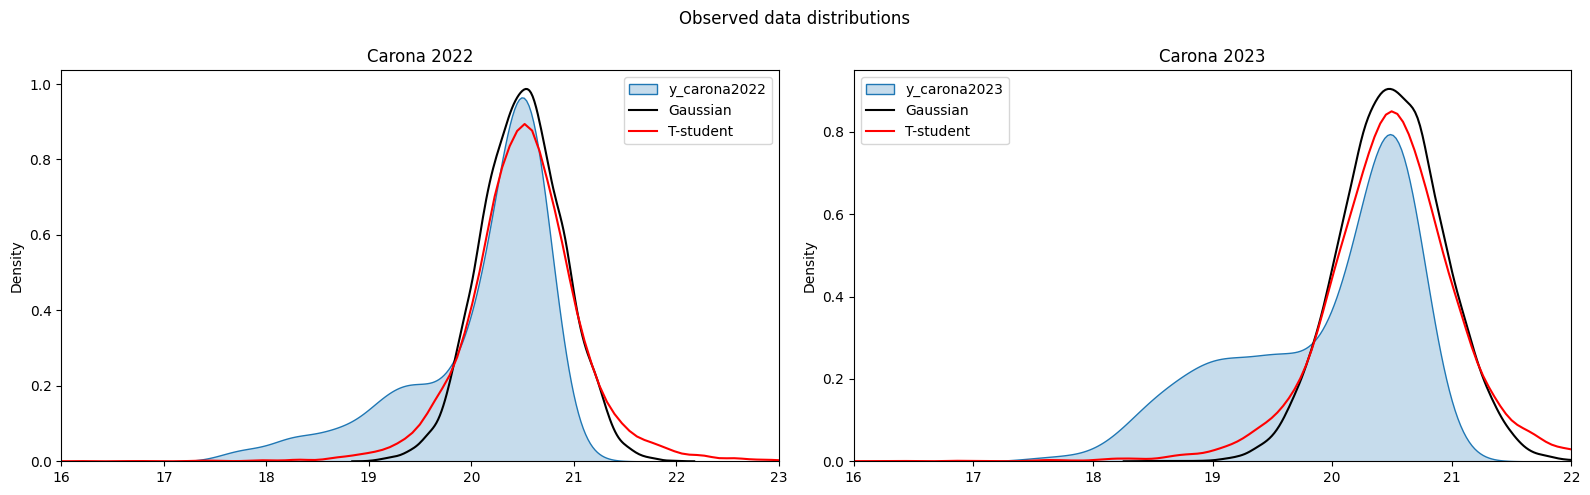

In [50]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))

sns.kdeplot(carona_2022, fill=True, ax=axs[0], label="y_carona2022")
sns.kdeplot(carona_2023, fill=True, ax=axs[1], label="y_carona2023")

sns.kdeplot(stats.norm.rvs(size=10000, loc=20.5, scale=0.4), ax=axs[0], color="black", label="Gaussian")
sns.kdeplot(stats.t.rvs(df=4, size=10000, loc=20.5, scale=0.4), ax=axs[0], color="red", label="T-student")

sns.kdeplot(stats.norm.rvs(size=10000, loc=20.5, scale=0.43), ax=axs[1], color="black", label="Gaussian")
sns.kdeplot(stats.t.rvs(df=4, size=10000, loc=20.5, scale=0.43), ax=axs[1], color="red", label="T-student")


for i in range(2):
    axs[i].legend()

axs[0].set_title("Carona 2022")
axs[1].set_title("Carona 2023")
axs[0].set_xlim(16, 23)
axs[1].set_xlim(16, 22)

fig.suptitle("Observed data distributions")
plt.tight_layout()

As before, we opted for the T-distribution because it is more permissive, meaning that it allows values further away from the distribution expected value, so that it takes into account the presence of the outliers.

In [51]:
with pm.Model() as model:
    sigma_2022 = pm.HalfNormal("sigma_2022", sigma=3)
    mean_2022 = pm.Normal("mean_2022", mu=20, sigma=0.5)
    sigma_2023 = pm.HalfNormal("sigma_2023", sigma=3)
    mean_2023 = pm.Normal("mean_2023", mu=20, sigma=0.5)

    y_2022 = pm.StudentT("y_2022", nu=4, observed=carona_2022, mu=mean_2022, sigma=sigma_2022)
    y_2023 = pm.StudentT("y_2023", nu=4, observed=carona_2023, mu=mean_2023, sigma=sigma_2023)

    diff = pm.Deterministic ("diff", mean_2023 - mean_2022)
    trace_ht_2 = pm.sample()

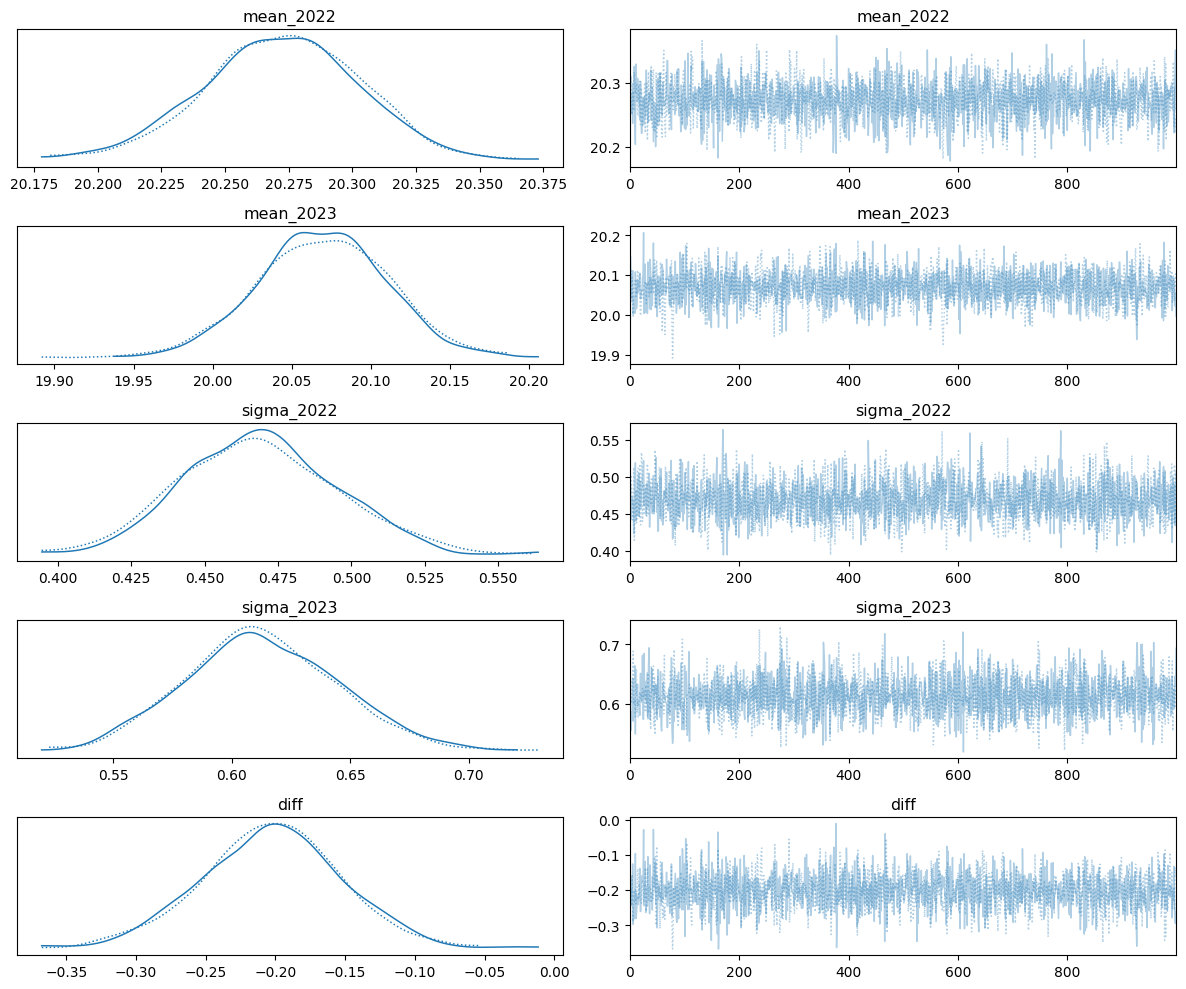

In [52]:
az.plot_trace(trace_ht_2)
plt.tight_layout();

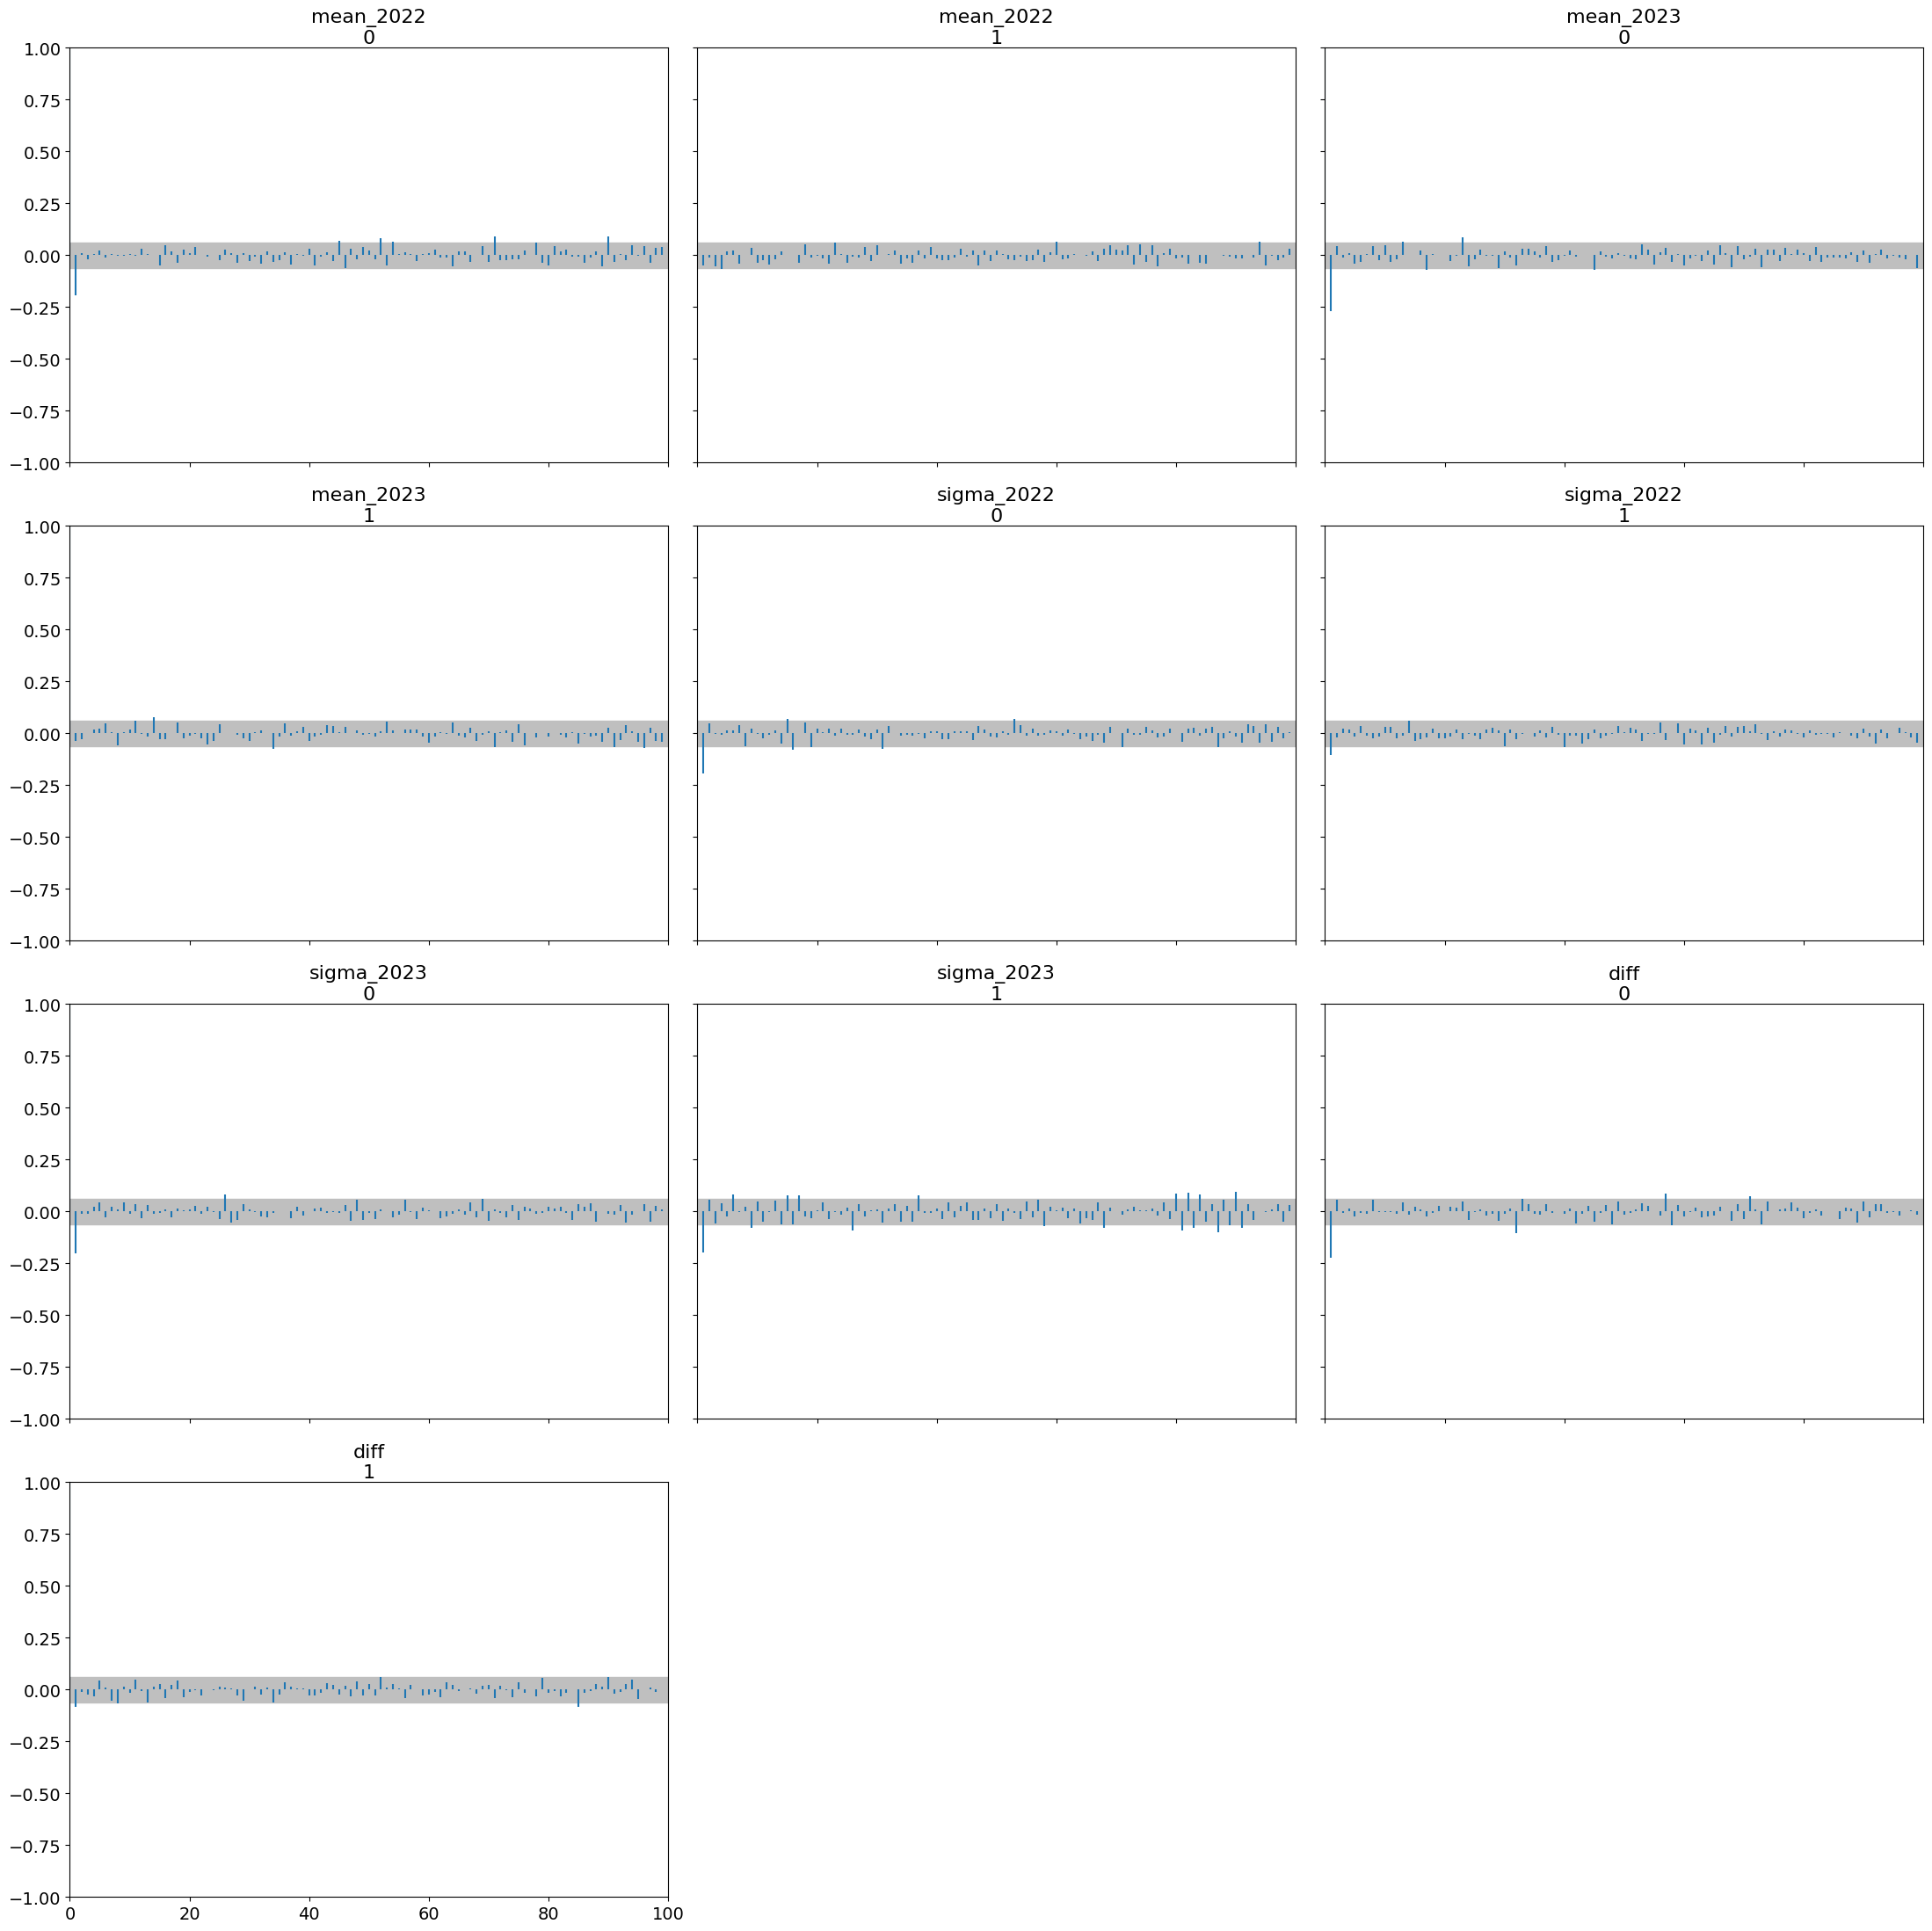

In [53]:
az.plot_autocorr(trace_ht_2)
plt.tight_layout();

The traces for the mean and sigma parameters for both years exhibit stable convergence, as indicated by the consistency in the trace plots that resemble white noise, suggesting that the sampling chains are mixing well. There's a strong overlap in the distributions of the traces from different chains, which indicates good convergence and reliable estimates. The autocorrelation is minimal for lags of 2 and above, demonstrating that successive samples are largely independent.

In [54]:
az.summary(trace_ht_2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mean_2022   20.272  0.031  20.210   20.324      0.001    0.000    2674.0   
mean_2023   20.069  0.041  19.992   20.144      0.001    0.001    2889.0   
sigma_2022   0.469  0.026   0.422    0.520      0.001    0.000    2643.0   
sigma_2023   0.613  0.032   0.553    0.674      0.001    0.000    3283.0   
diff        -0.203  0.051  -0.302   -0.112      0.001    0.001    2841.0   

            ess_tail  r_hat  
mean_2022     1425.0    1.0  
mean_2023     1540.0    1.0  
sigma_2022    1799.0    1.0  
sigma_2023    1592.0    1.0  
diff          1696.0    1.0

The r_hat values being 1.0 across all parameters further reinforce the reliability of these results, indicating that the chains have converged well.

<Axes: title={'center': 'diff'}>

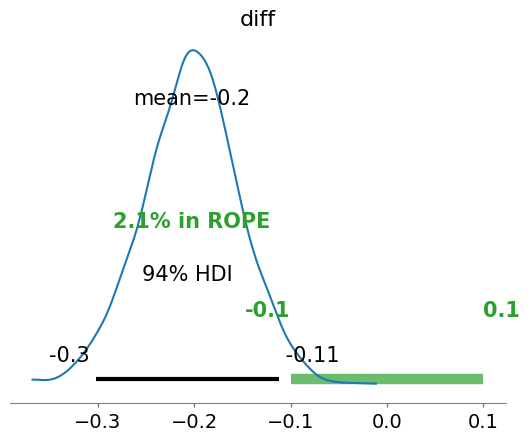

In [55]:
az.plot_posterior(trace_ht_2, var_names=["diff"], rope=(-0.1, 0.1))

The conclusions from this hypothesis test suggest with confidence that, in light of the observed data, the mean difference in the parameter of interest between 2022 and 2023 is -0.2. The 94% Highest Density Interval (HDI) from the posterior distribution is between -0.29 and -0.1. Only 3.20% of the posterior distribution falls within the Region of Practical Equivalence (ROPE) of (-0.1, 0.1), which suggests that the observed difference is practically significant. The mean value of the parameter in 2022 is likely higher than in 2023, which aligns with the expected hypothesis.

##### Posterior predictive checks

In [56]:
mean_2022_vals, mean_2023_vals, std_2022_vals, std_2023_vals = (
    az.extract(trace_ht_2).mean_2022.values,
    az.extract(trace_ht_2).mean_2023.values,
    az.extract(trace_ht_2).sigma_2022.values,
    az.extract(trace_ht_2).sigma_2023.values
)

In [57]:
checks_2022 = get_posterior_predictive_checks(mean_2022_vals, std_2022_vals, size=len(carona_2022), n_checks=100)
checks_2023 = get_posterior_predictive_checks(mean_2023_vals, std_2023_vals, size=len(carona_2023), n_checks=100)

pd.concat([
    pd.DataFrame(checks_2022[0], columns=["Checks 2022"]),
    pd.DataFrame(checks_2023[0], columns=["Checks 2023"])
], axis=1)

Checks 2022  Checks 2023
0      22.117111    20.069252
1      20.415509    19.002067
2      19.921272    19.416461
3      20.325694    19.791976
4      20.320760    20.159136
..           ...          ...
335    20.001927          NaN
336    20.193529          NaN
337    19.785521          NaN
338    20.729383          NaN
339    19.809526          NaN

[340 rows x 2 columns]

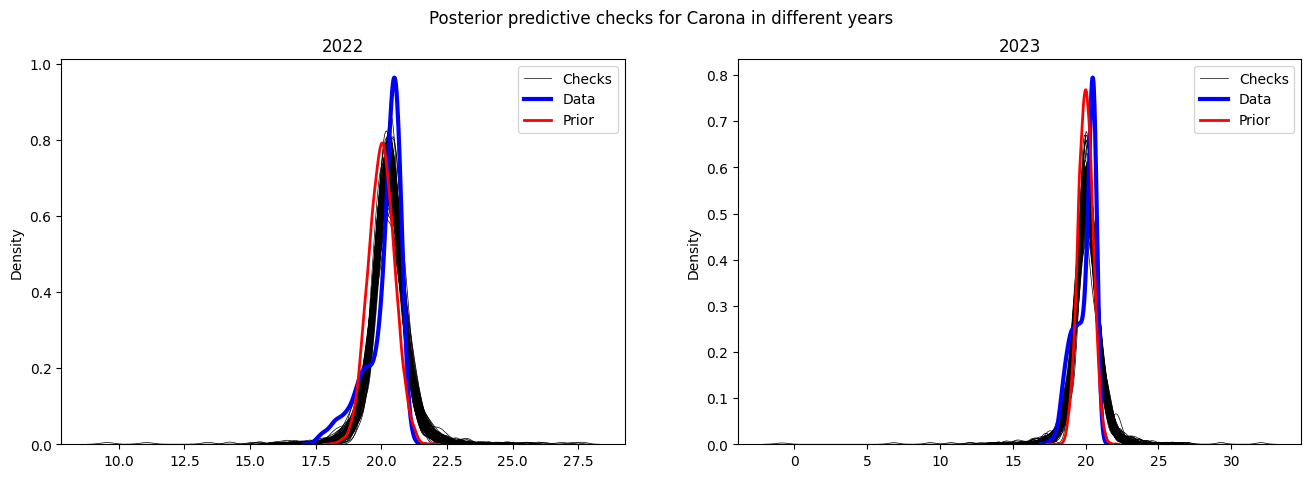

In [58]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))

for i, check in enumerate(checks_2022):
    if i == 0:
        sns.kdeplot(check, ax=axs[0], linewidth=0.5, color="black", label="Checks")
        continue

    sns.kdeplot(check, ax=axs[0], linewidth=0.5, color="black")

for i, check in enumerate(checks_2023):
    if i == 0:
        sns.kdeplot(check, ax=axs[1], linewidth=0.5, color="black", label="Checks")
        continue

    sns.kdeplot(check, ax=axs[1], linewidth=0.5, color="black")

axs[0].set_title("2022")
axs[1].set_title("2023")
fig.suptitle("Posterior predictive checks for Carona in different years")

sns.kdeplot(carona_2022, ax=axs[0], linewidth=3, color="b", label="Data")
sns.kdeplot(carona_2023, ax=axs[1], linewidth=3, color="b", label="Data")

sns.kdeplot(stats.norm.rvs(size=5000, loc=20, scale=0.5), ax=axs[0], linewidth=2, color="r", label="Prior")
sns.kdeplot(stats.norm.rvs(size=5000, loc=20, scale=0.5), ax=axs[1], linewidth=2, color="r", label="Prior")

axs[0].legend()
axs[1].legend();

The posterior predictive checks demonstrate that the Bayesian models for Carona in 2022 and 2023 provide a good fit to the observed data. In both years, the 'Checks' curves, representing simulated data from the posterior, align closely with the 'Data' curve, indicating that the models accurately capture the central tendency and variability of the observed measurements. The 'Prior' distributions show a narrower spread around the mean, reflecting our initial assumptions before observing the data. The fact that the 'Checks' and 'Data' curves overlap suggests that the posterior distributions are well-tuned to the nuances of the actual data. Despite some slight deviations, such as the wider tails in the posterior predictive checks, the models appear robust and provide credible predictive distributions for the Carona data in both years.

##### Prior sensitivity

In [59]:
lam = 1 / 2 # Expected value distribution: 2
stats.expon.rvs(10, scale=1/lam)

10.674025821058652

In [60]:
with pm.Model() as model:
    sigma_2022 = pm.Exponential("sigma_2022", lam=lam)
    mean_2022 = pm.Normal("mean_2022", mu=21, sigma=1)
    sigma_2023 = pm.Exponential("sigma_2023", lam=lam)
    mean_2023 = pm.Normal("mean_2023", mu=21, sigma=1)

    y_2022 = pm.StudentT("y_2022", nu=4, observed=carona_2022, mu=mean_2022, sigma=sigma_2022)
    y_2023 = pm.StudentT("y_2023", nu=4, observed=carona_2023, mu=mean_2023, sigma=sigma_2023)

    diff = pm.Deterministic ("diff", mean_2023 - mean_2022)
    trace_sensitivity_2 = pm.sample()

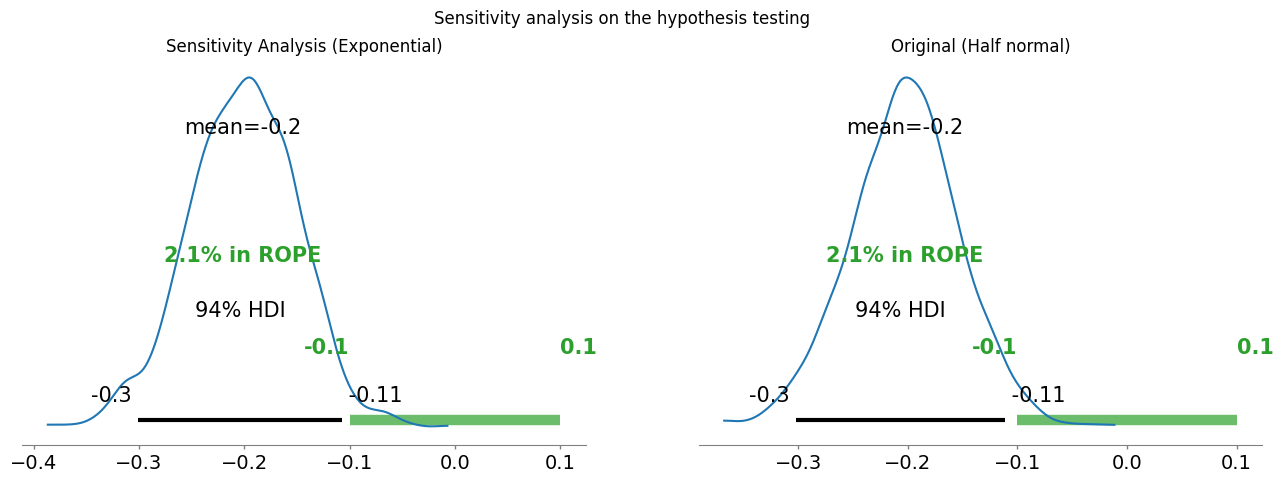

In [61]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
az.plot_posterior(trace_sensitivity_2, var_names=["diff"], rope=(-0.1, 0.1), ax=axs[0])
az.plot_posterior(trace_ht_2, var_names=["diff"], rope=(-0.1, 0.1), ax=axs[1])

axs[0].set_title("Sensitivity Analysis (Exponential)")
axs[1].set_title("Original (Half normal)")

fig.suptitle("Sensitivity analysis on the hypothesis testing");

The small percentage within the Region of Practical Equivalence (ROPE) for both priors indicates that the observed difference is likely to be substantial and not due to random variation. The 94% Highest Density Interval (HDI) is also similar for both priors, further suggesting that the results are robust to the choice of prior. This consistency supports the reliability of the hypothesis test's conclusions.

# Linear regression

In [62]:
df_gr = df_gr.reset_index()

In [63]:
df_gr

year  period  Camignolo  Campo vallemaggia   Canobbio     Carona  \
0   2022       0  20.333898          21.136585  19.383051  20.266102   
1   2022       1  19.983333          21.080000  18.953333  19.834426   
2   2022       2  20.242623          21.483607  19.266667  20.047541   
3   2022       3  20.438710          21.300000  19.489796  20.265574   
4   2022       4  20.226230          21.336364  19.235556  20.026923   
5   2022       5  20.157377          20.940351  19.208197  20.121739   
6   2023       0  20.040678          21.094828  19.072414  20.001695   
7   2023       1  20.122951          21.367797  19.161017  20.036667   
8   2023       2  19.946667          21.445902  18.864912  19.586885   
9   2023       3  20.296774          21.418644  19.389831  20.034483   
10  2023       4  19.922642          21.402128  18.946154  19.849153   
11  2023       5  20.353333          21.230000  19.503333  20.263333   

      Chiasso  Giubiasco     Gnosca    Locarno       Msio     M.Lema  \
0   19.076271  19.730508  20.581034  20.323077  19.277193  20.427119   
1   18.788333  19.393333  20.298361  19.914754  18.917391  20.239344   
2   19.026230  19.701639  20.886885  20.195082  19.214754  20.354098   
3   19.259677  19.804839  21.196667  20.359677  19.466102  20.412903   
4   19.024590  19.576271  20.570492  20.050000  19.236066  20.271154   
5   18.772414  19.631148  20.239286  20.075862  18.984746  20.275410   
6   18.715517  19.437288  20.310526  20.063793  18.950000  20.218182   
7   18.975410  19.608197  20.491803  20.113115  19.155738  20.143396   
8   18.577049  19.391803  20.463934  19.918033  18.842623  20.076667   
9   19.127419  19.762295  20.745098  20.319231  19.387097  20.285185   
10  18.814815  19.424528  20.443860  19.847619  19.047273  20.097917   
11  19.176667  19.773333  20.526667  20.320000  19.563333  20.326667   

    Monteggio  Lucomagno      Bodio  
0   20.484746  21.832143  20.226114  
1   20.163333  21.857407  19.778103  
2   20.332787  21.781818  20.098361  
3   20.454839  21.925424  20.254839  
4   20.308197  21.812500  20.142623  
5   20.225424  21.770588  20.046467  
6   20.244828  21.703571  20.061299  
7   20.172131  21.780357  20.200000  
8   19.947541  21.849123  20.001639  
9   20.236735  21.896364  20.193548  
10  20.148333  21.672093  19.821108  
11  20.493333  21.993333  20.093333

In [64]:
altitudes = {
    "Camignolo": 458,
    "Campo vallemaggia": 1360,
    "Canobbio": 400,
    "Carona": 1100,
    "Chiasso": 230,
    "Giubiasco": 242,
    "Gnosca": 500,
    "Locarno": 195,
    "Msio": 367,
    "M.Lema":  1621,
    "Monteggio": 420,
    "Lucomagno": 1926,
    "Bodio": 321
}

In [65]:
inhabitants = {
    "Camignolo": 733 ,
    "Campo vallemaggia": 56 ,
    "Canobbio": 2121,
    "Carona": 737,
    "Chiasso": 7580,
    "Giubiasco": 8751,
    "Gnosca": 752,
    "Locarno": 16030,
    "Msio": 15800,
    "M.Lema":  0,
    "Monteggio": 896,
    "Lucomagno": 0,
    "Bodio": 1037
}

In [66]:
def get_reg_df(df, columns):
    reg_df = pd.DataFrame()

    for col in columns:
        altitude = pd.Series(np.full(len(df), altitudes[col]), name="Altitude")
        inhab = pd.Series(np.full(len(df), inhabitants[col]), name="Altitude")
        locality = pd.Series(np.array([col]*len(df)), name="Loc")
        loc_df = pd.concat([df.iloc[:, :2], df.loc[:, col], altitude, inhab, locality], axis=1)
        loc_df.columns = ("year", "period", "y", "altitude", "inhabitants", "loc")
        reg_df = pd.concat([reg_df, loc_df])
    return reg_df

In [67]:
reg_df = get_reg_df(df_gr, df_gr.columns[2:-1])

In [68]:
reg_df_test = get_reg_df(df_gr, df_gr.columns[-1:])

In [69]:
reg_df.head()

year  period          y  altitude  inhabitants        loc
0  2022       0  20.333898       458          733  Camignolo
1  2022       1  19.983333       458          733  Camignolo
2  2022       2  20.242623       458          733  Camignolo
3  2022       3  20.438710       458          733  Camignolo
4  2022       4  20.226230       458          733  Camignolo

In [70]:
reg_df_test.head()

year  period          y  altitude  inhabitants    loc
0  2022       0  20.226114       321         1037  Bodio
1  2022       1  19.778103       321         1037  Bodio
2  2022       2  20.098361       321         1037  Bodio
3  2022       3  20.254839       321         1037  Bodio
4  2022       4  20.142623       321         1037  Bodio

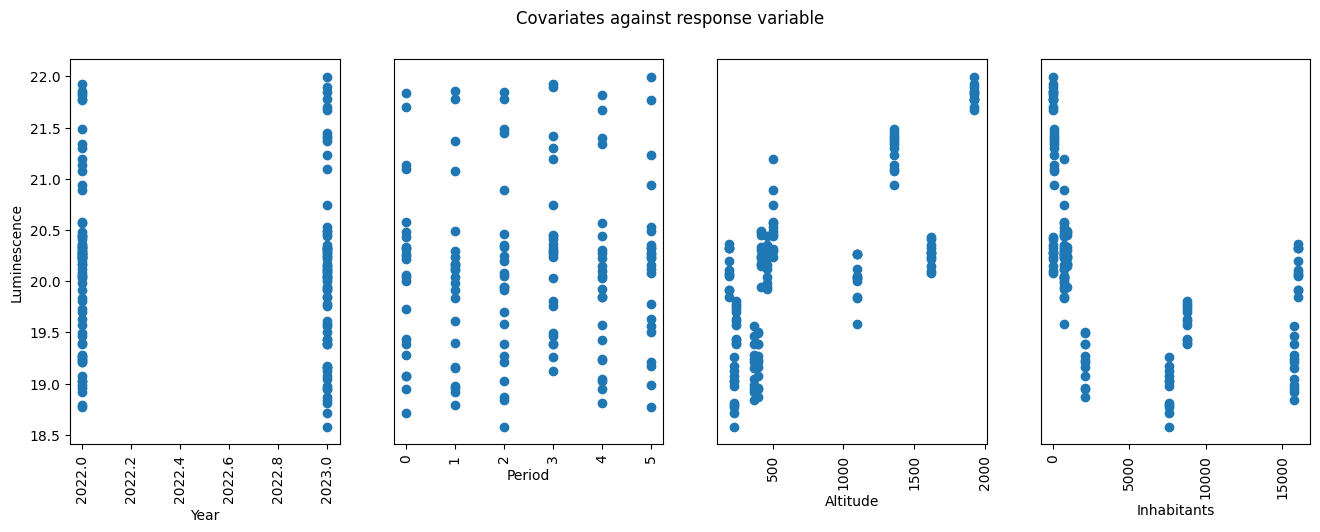

In [71]:
fig, axs = plt.subplots(ncols=4, figsize=(16, 5))

for i, col in enumerate([col for col in reg_df.columns if col != "y"]):
    if i > 3:
        break

    if i == 0:
        axs[i].set_ylabel("Luminescence")
    else:
        axs[i].set_yticks([])
    axs[i].scatter(reg_df[col], reg_df["y"])
    axs[i].set_xlabel(f"{col.title()}")
    axs[i].tick_params(axis='x', rotation=90)

fig.suptitle("Covariates against response variable");

The scatter plots illustrate the exploratory analysis of the relationships between luminance and various covariates including year, period, altitude, and inhabitants. Since Year, Period and Inhabitants are not linearly correlated, we only considered Altitude.

$$ Model \ definition: $$
$$ \beta_{0} \sim N(\mu_{\beta_0}, \sigma_{\beta_0}),\ intercept $$
$$ \beta_{1} \sim N(\mu_{\beta_1}, \sigma_{\beta_1}),\ slope $$
$$ \epsilon \sim HN(\xi) $$
$$ Y | \epsilon, \ \beta_{0}, \ \beta_{1} \sim N(\beta_{0} + \ \beta_{1}*Altitude, \epsilon) $$

In [72]:
reg_df["altitude"] -= reg_df["altitude"].mean() # Center the covariate

In [73]:
reg_df.head()

year  period          y    altitude  inhabitants        loc
0  2022       0  20.333898 -276.916667          733  Camignolo
1  2022       1  19.983333 -276.916667          733  Camignolo
2  2022       2  20.242623 -276.916667          733  Camignolo
3  2022       3  20.438710 -276.916667          733  Camignolo
4  2022       4  20.226230 -276.916667          733  Camignolo

In [74]:
1.5*reg_df["y"].std()

1.2472715998819741

In [75]:
pd.DataFrame(stats.halfnorm.rvs(scale=1.9, size=1000)).describe()

0
count  1000.000000
mean      1.536885
std       1.153615
min       0.000317
25%       0.608189
50%       1.331131
75%       2.221988
max       6.408659

Priors (Data-dependent)

In [76]:
b_0_mean, b_0_std = reg_df["y"].mean(), 2*reg_df["y"].std()
b_1_mean, b_1_std = 0, 2.5*(reg_df["y"].std()/reg_df["altitude"].std())
epsilon_xi = 1.5*reg_df["y"].std()

In [77]:
b_0 = stats.norm(b_0_mean, b_0_std)
b_1 = stats.norm(b_1_mean, b_1_std)
epsilon = stats.halfnorm(epsilon_xi)

##### Prior analysis

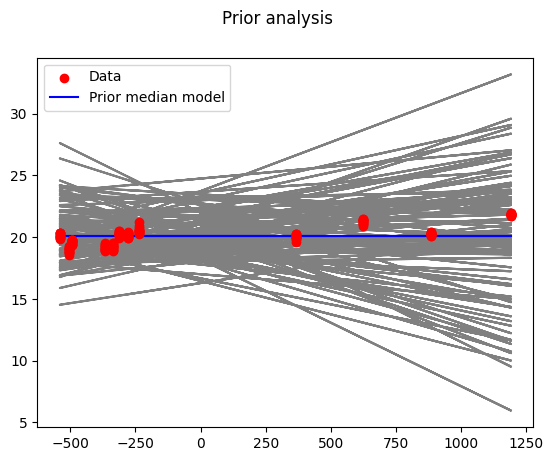

In [78]:
fig, ax = plt.subplots()
for _ in range(100):
    b_0_obs, b_1_obs = b_0.rvs(), b_1.rvs()
    ax.plot(reg_df["altitude"], reg_df["altitude"]*b_1_obs + b_0_obs, c="gray")

ax.scatter(reg_df["altitude"], reg_df["y"], c="red", zorder=10, label="Data")
ax.plot(reg_df["altitude"], reg_df["altitude"]*b_1.median() + b_0.median(), c="blue", label="Prior median model")
fig.suptitle("Prior analysis")
ax.legend();

The regression analysis, focusing solely on altitude as a covariate, has been structured with data-derived priors to reflect our current understanding of the relationship between altitude and luminance. The prior analysis plot illustrates the influence of altitude on luminance, with the spread of gray lines representing possible regression lines drawn from the priors.
As expected, the prior median model goes through a point close to $\bar{y}$ (20.11) for centered altitude values close to 0.
Moreover, the large uncertainty of the priors derived from the gray lines reflects unavailable knowledge.  

In [79]:
with pm.Model() as model:
    beta_0 = pm.Normal("beta_0", mu=b_0_mean, sigma=b_0_std)
    beta_1 = pm.Normal("beta_1", mu=b_1_mean, sigma=b_1_std)
    epsilon = pm.HalfNormal("epsilon", sigma=epsilon_xi)

    y = pm.Normal("y", mu=beta_0 + beta_1*reg_df["altitude"], sigma=epsilon, observed=reg_df["y"])

    trace_reg = pm.sample()

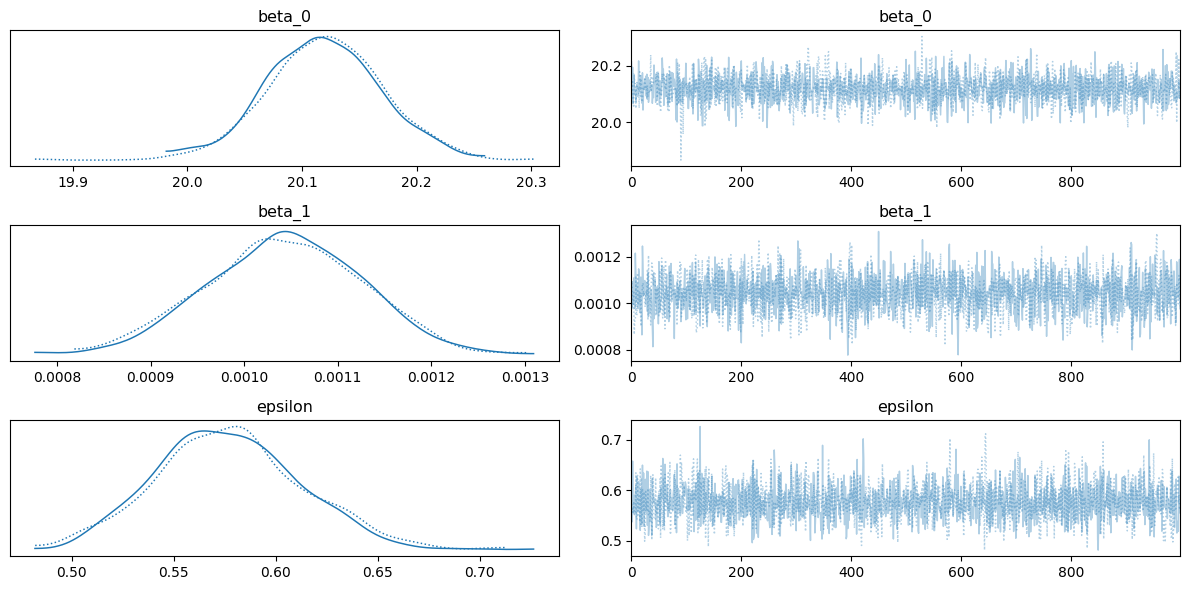

In [80]:
az.plot_trace(trace_reg)
plt.tight_layout();

The MCMC trace plots presented here indicate a well-converged Bayesian linear regression model with parameters beta_0 (intercept), beta_1 (slope), and epsilon (error term). Trace plots exhibit no visible trends or periodicities, indicating good mixing and stationarity of the chains. These results suggest that the posterior distributions of the model parameters are reliable for inference and prediction regarding the effect of altitude on luminance.

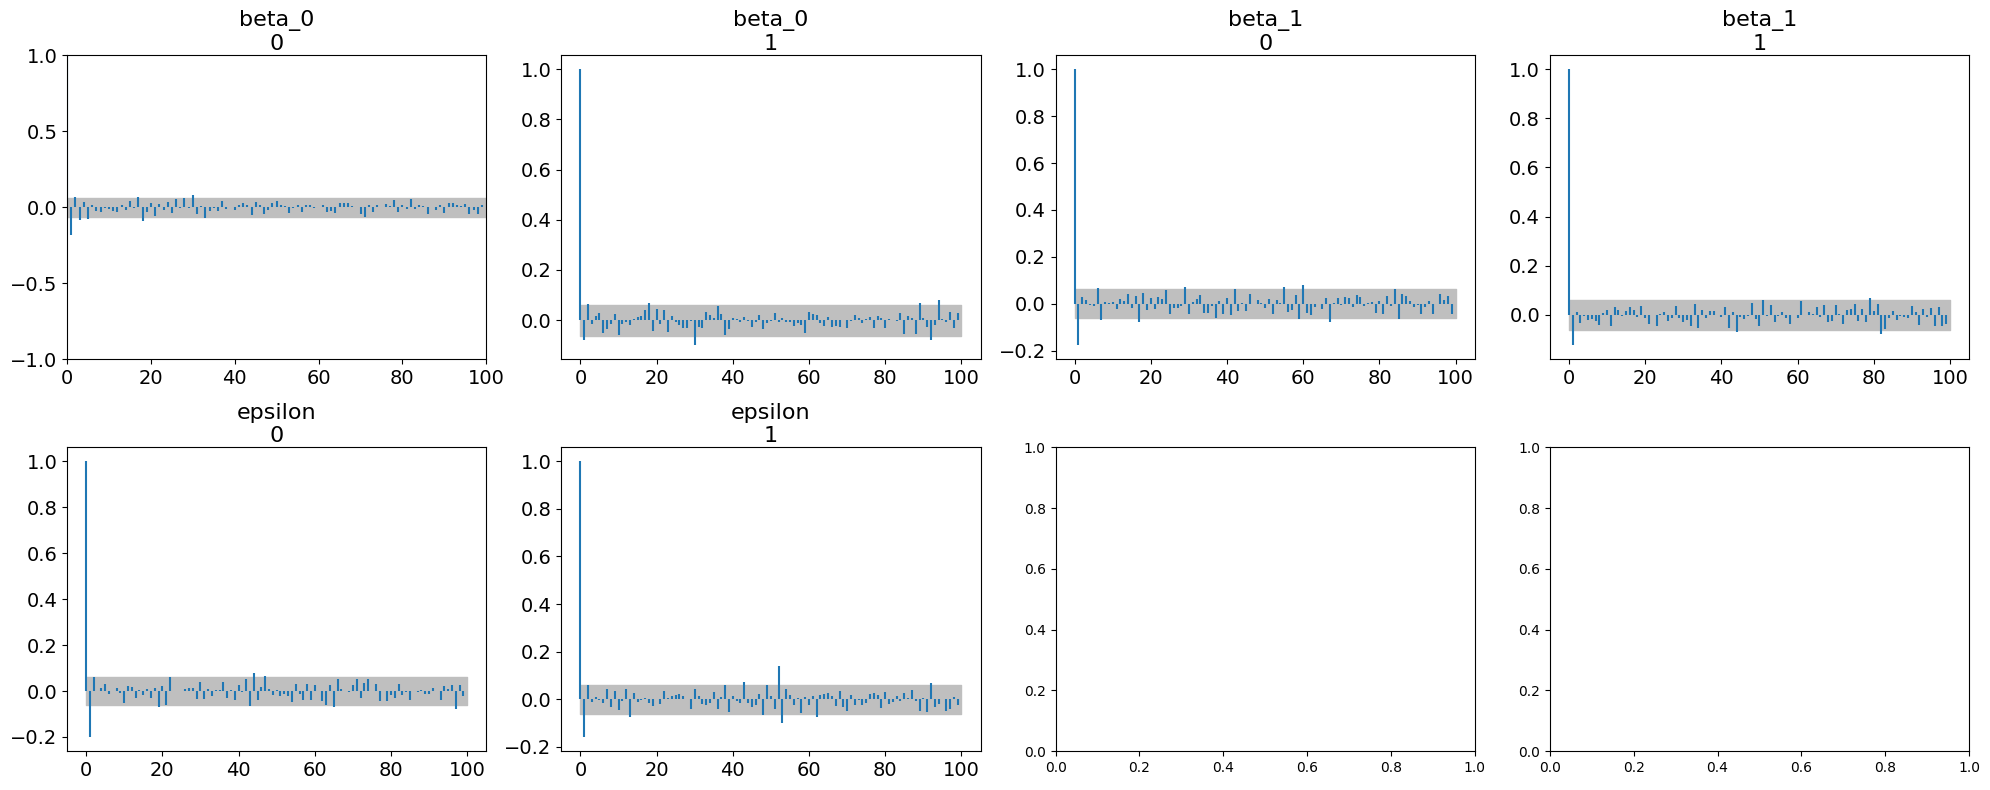

In [81]:
_, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
az.plot_autocorr(trace_reg, ax=axs)
plt.tight_layout();

The autocorrelation plots for the parameters of the Bayesian linear regression model (beta_0, beta_1, and epsilon) indicate that the samples are largely independent, as shown by the autocorrelation dropping off quickly to near zero after the first lag.

In [82]:
trace_vals = az.extract(trace_reg)

In [83]:
len(trace_vals.beta_0)

2000

In [84]:
b_0_posterior_median, b_1_posterior_median = trace_reg.median().posterior.beta_0.values, trace_reg.median().posterior.beta_1.values

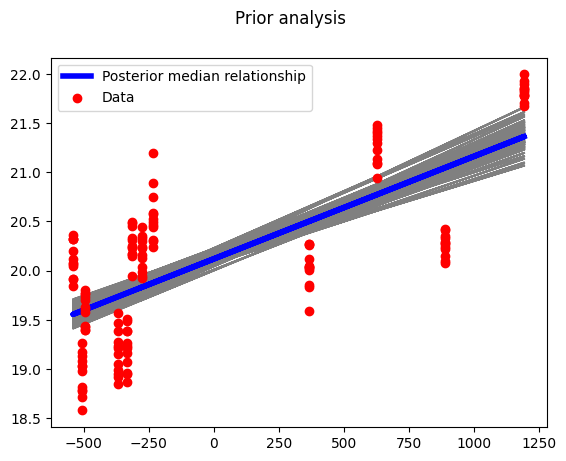

In [85]:
fig, ax = plt.subplots()
for i, (b0, b1) in enumerate(zip(trace_vals.beta_0.values, trace_vals.beta_1.values)):
    if i > 100:
        break
    ax.plot(reg_df["altitude"], reg_df["altitude"]*b1 + b0, c="gray")

ax.plot(reg_df["altitude"], reg_df["altitude"]*b_1_posterior_median + b_0_posterior_median, c="b", label="Posterior median relationship", linewidth=4)
ax.scatter(reg_df["altitude"], reg_df["y"], c="red", zorder=10, label="Data")

fig.suptitle("Prior analysis")
ax.legend();

The posterior analysis plot confirms a positive relationship between altitude and luminances. The concentrated cluster of data points around the posterior median line suggests that the model captures the central trend in the data well.

In [86]:
def get_pred_dist_at(covar):
    y_new = []
    for b0, b1, eps in zip(trace_vals.beta_0.values, trace_vals.beta_1.values, trace_vals.epsilon.values):
        y_new.append(stats.norm.rvs(loc=b0+b1*covar, scale=eps))

    return np.array(y_new)

In [87]:
y_bodio_vals = get_pred_dist_at(altitudes["Bodio"])

In [88]:
y_bodio_gaussian = stats.norm(loc=y_bodio_vals.mean(), scale=y_bodio_vals.std())

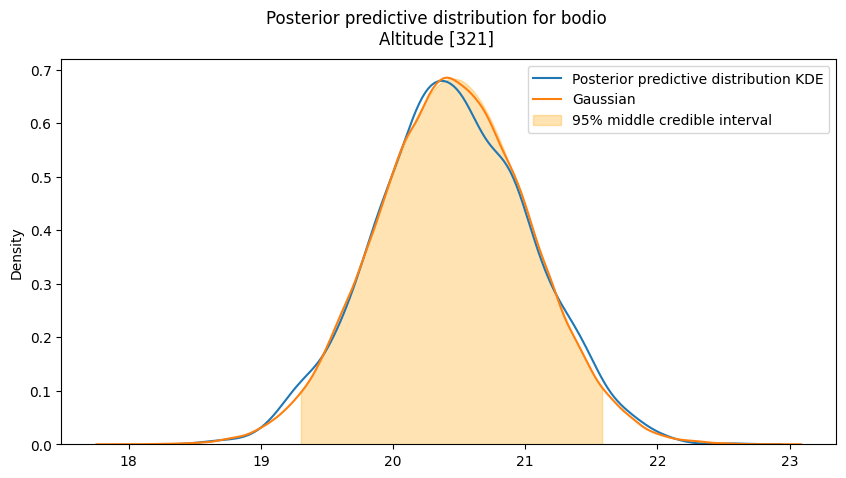

In [89]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(y_bodio_vals, ax=ax, label="Posterior predictive distribution KDE")
sns.kdeplot(y_bodio_gaussian.rvs(size=100_000), ax=ax, label="Gaussian")

left, right = np.quantile(y_bodio_vals, 0.025), np.quantile(y_bodio_vals, 0.975)
ax.fill_between(np.linspace(left, right, 1000), [y_bodio_gaussian.pdf(x) for x in np.linspace(left, right, 1000)], label="95% middle credible interval", color="orange", alpha=0.3)
ax.legend()
fig.suptitle(f"Posterior predictive distribution for bodio\nAltitude [{altitudes['Bodio']}]");

In [90]:
y_bodio_vals.mean(), np.quantile(y_bodio_vals, 0.025), np.quantile(y_bodio_vals, 0.975)

(20.453354759046647, 19.30243861689544, 21.581055851813424)

The KDE plot shows the distribution of predicted luminance values, which closely follows the overlaid Gaussian curve, suggesting that the predictions are well-modeled by a normal distribution. The 95% middle credible interval highlighted in orange represents the range within which we can expect the true luminance values to fall with 95% probability. This interval, reflecting the model's uncertainty, is reasonably narrow, indicating a good level of precision in the predictions.

# Hierarchical modeling

Create a mapping between locations so that each observation can be associated to its respective prior

In [91]:
locs = reg_df["loc"].unique()
loc_conv = {k:v for k,v in zip(locs, range(len(locs)))}
loc_map = lambda x: loc_conv[x]

In [92]:
pd.concat([reg_df["loc"].apply(loc_map), reg_df["loc"]], axis=1) # Coding for each of the observations representing its location

loc        loc
0    0  Camignolo
1    0  Camignolo
2    0  Camignolo
3    0  Camignolo
4    0  Camignolo
..  ..        ...
7   11  Lucomagno
8   11  Lucomagno
9   11  Lucomagno
10  11  Lucomagno
11  11  Lucomagno

[144 rows x 2 columns]

In [93]:
len(reg_df["loc"].unique())

12

In [94]:
pd.DataFrame(stats.halfnorm.rvs(size=1000, scale=1)).describe()

0
count  1000.000000
mean      0.802659
std       0.574739
min       0.000748
25%       0.349202
50%       0.689381
75%       1.137131
max       3.196470

$$
\mu_{brill} \sim N(20, 0.25) \\
\sigma_{brill} \sim HN(1) \\
\mu_{i} \sim N(\mu_{brill}, \sigma_{brill})\  \  \forall i \in [0, 11]\\
\sigma_{loc} \sim HN(3) \\
$$

Since we are modeling Ticino brightness values, we chose the prior hyperparameters for the global mean as 20 and 0.25 because looking on the same website as for the hypothesis testing, the mean values range from around 19 to around 21. Concerning the global standard deviation, we considered as possible value 0.5=(21-19)/4, whereas for the location standard deviation we considered the same as in the hypothesis testing for the same reasoning explained above.

In [95]:
with pm.Model() as hier_model:
    mu_brill = pm.Normal ('mu_brill', 20,  0.5)
    sigma_brill = pm.HalfNormal ('sigma_brill', sigma=5)
    mu_loc = pm.Normal ('mu_loc', mu=mu_brill, sigma=sigma_brill, shape=len(reg_df["loc"].unique()))
    sigma_loc = pm.HalfNormal ('sigma_loc', sigma=3)

    y_loc = pm.StudentT('y_loc', nu=4, mu=mu_loc[reg_df["loc"].apply(loc_map)],  sigma = sigma_loc, observed = reg_df["y"])

    trace_hier = pm.sample()

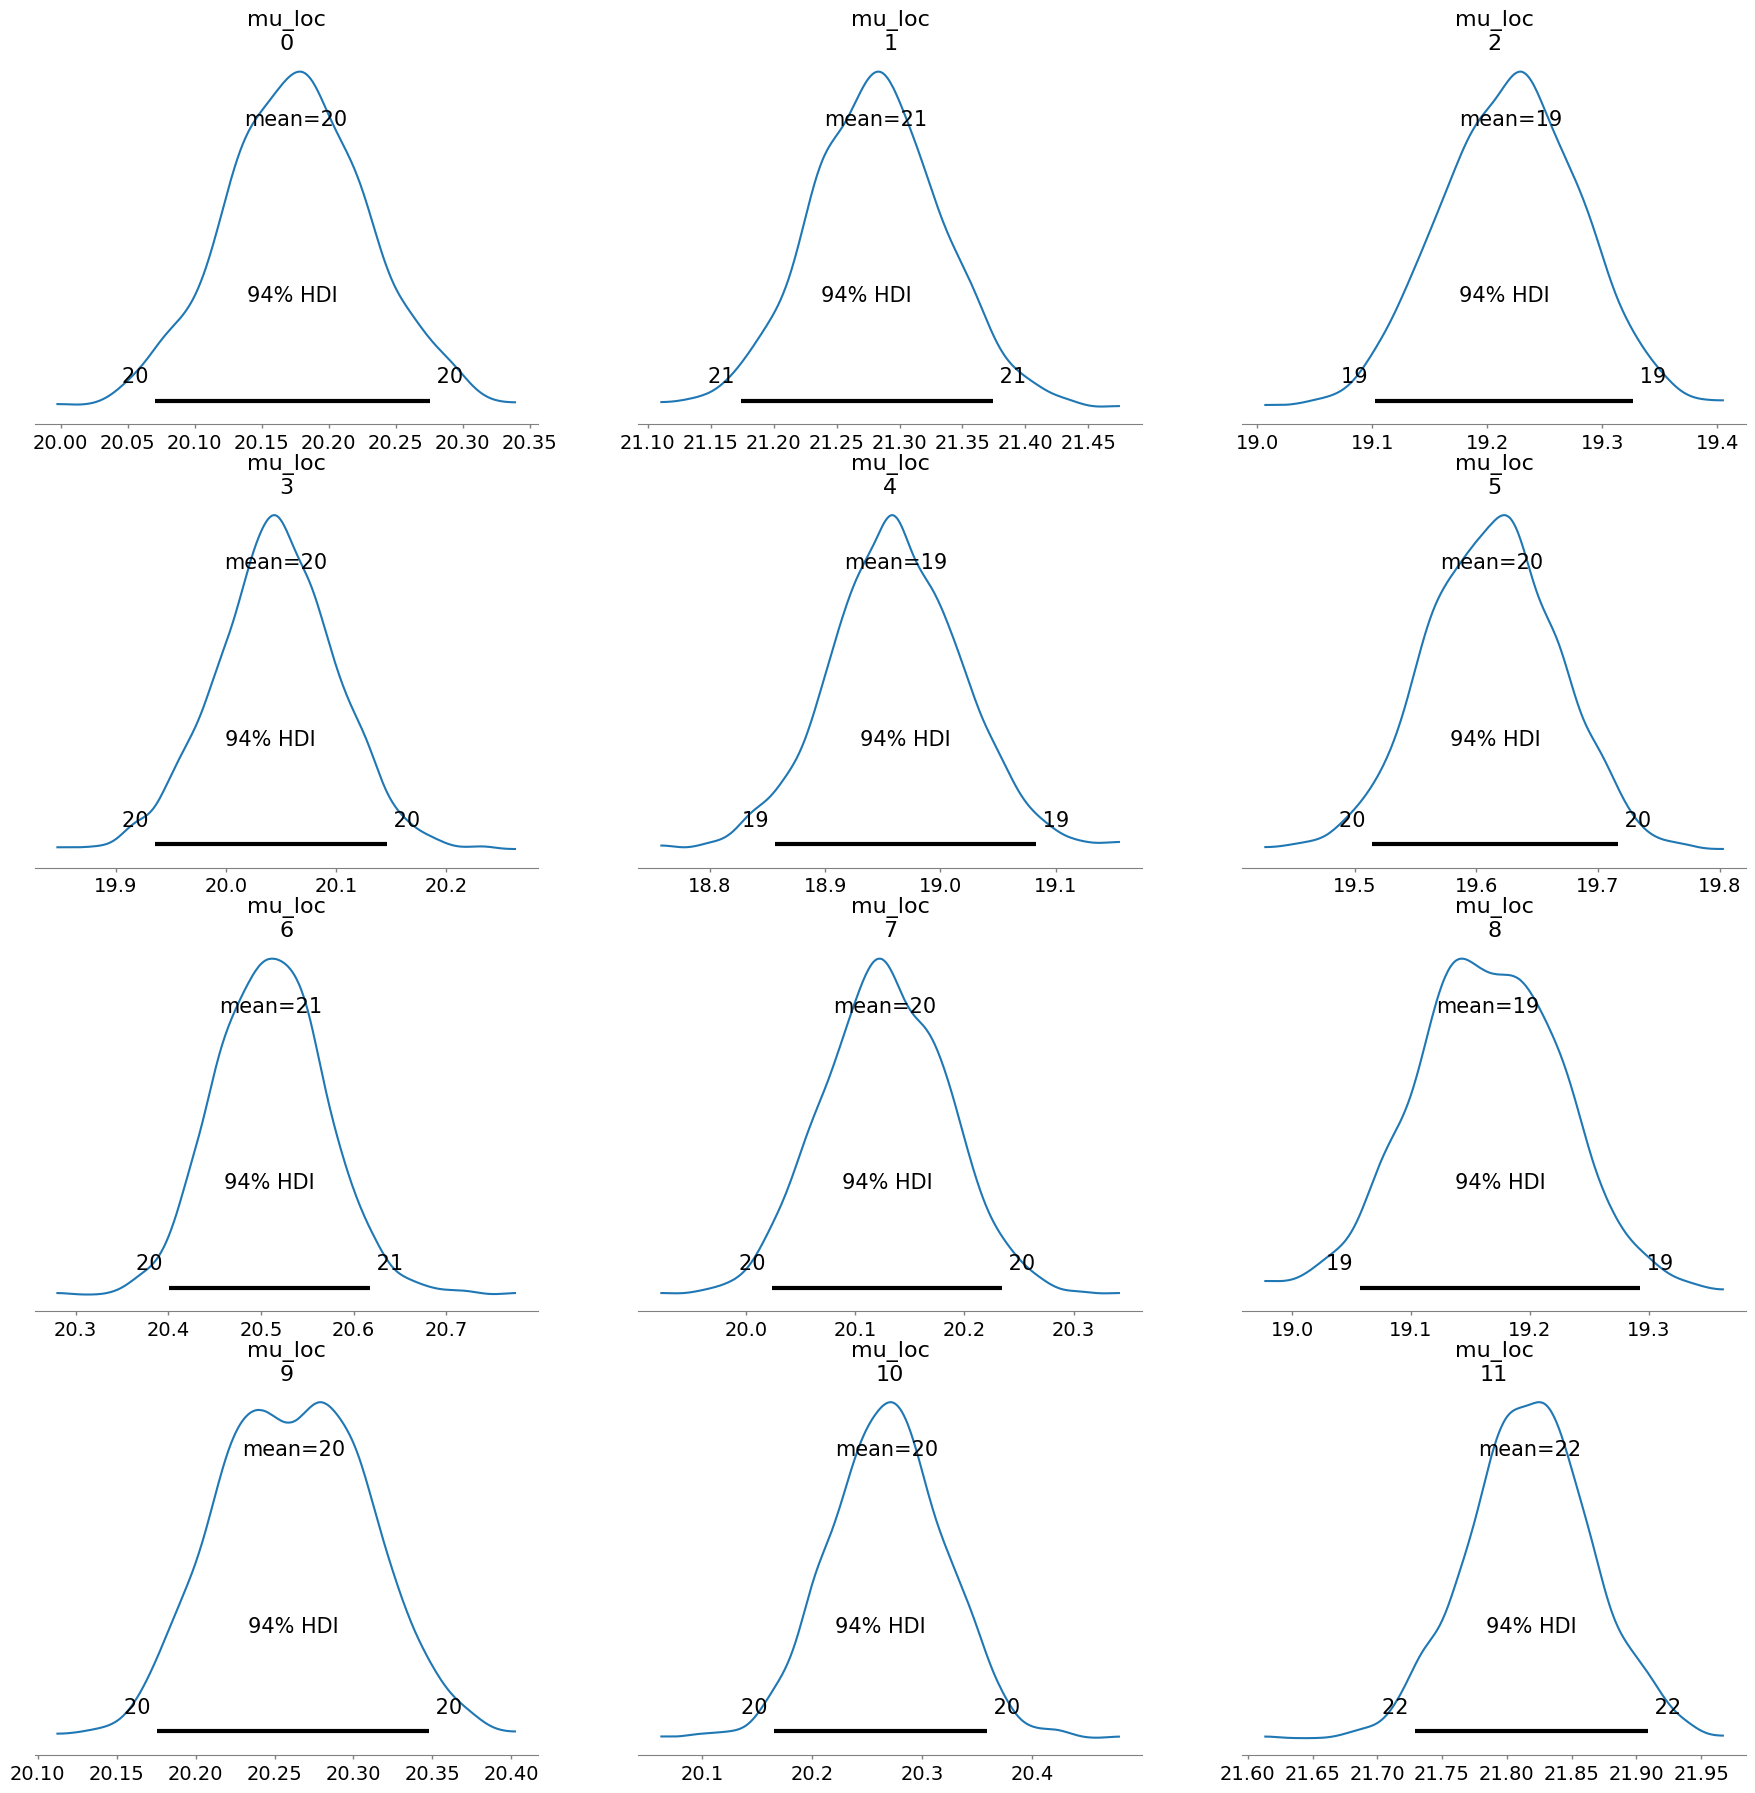

In [96]:
az.plot_posterior(trace_hier, var_names=[f"mu_loc"]);

In [97]:
summary = az.summary(trace_hier)
summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_brill     20.096  0.235  19.639   20.510      0.004    0.003    2959.0   
mu_loc[0]    20.176  0.054  20.070   20.276      0.001    0.001    3878.0   
mu_loc[1]    21.281  0.053  21.174   21.374      0.001    0.001    4108.0   
mu_loc[2]    19.220  0.061  19.102   19.327      0.001    0.001    3366.0   
mu_loc[3]    20.045  0.056  19.936   20.146      0.001    0.001    3921.0   
mu_loc[4]    18.961  0.059  18.856   19.083      0.001    0.001    3247.0   
mu_loc[5]    19.613  0.055  19.514   19.717      0.001    0.001    4390.0   
mu_loc[6]    20.510  0.059  20.401   20.617      0.001    0.001    3679.0   
mu_loc[7]    20.127  0.057  20.024   20.234      0.001    0.001    3699.0   
mu_loc[8]    19.165  0.063  19.057   19.293      0.001    0.001    3485.0   
mu_loc[9]    20.262  0.047  20.176   20.348      0.001    0.001    3355.0   
mu_loc[10]   20.268  0.052  20.166   20.359      0.001    0.001    5096.0   
mu_loc[11]   21.818  0.047  21.729   21.909      0.001    0.001    3817.0   
sigma_brill   0.944  0.237   0.571    1.398      0.005    0.004    2825.0   
sigma_loc     0.157  0.012   0.133    0.179      0.000    0.000    3156.0   

             ess_tail  r_hat  
mu_brill       1456.0    1.0  
mu_loc[0]      1489.0    1.0  
mu_loc[1]      1357.0    1.0  
mu_loc[2]      1469.0    1.0  
mu_loc[3]      1385.0    1.0  
mu_loc[4]      1432.0    1.0  
mu_loc[5]      1513.0    1.0  
mu_loc[6]      1415.0    1.0  
mu_loc[7]      1442.0    1.0  
mu_loc[8]      1216.0    1.0  
mu_loc[9]      1499.0    1.0  
mu_loc[10]     1184.0    1.0  
mu_loc[11]     1483.0    1.0  
sigma_brill    1368.0    1.0  
sigma_loc      1527.0    1.0


The hierarchical modeling approach applied to location-specific luminance data shows that the posterior distributions of the mean luminance (mu_loc) for each location are well-defined with narrow 94% Highest Density Intervals (HDIs). This indicates a precise estimation of the luminance means within each location. The HDIs vary slightly across locations, which suggests there are location-specific factors influencing luminance levels. Additionally, the model parameters mu_brill and sigma_brill have posterior distributions with reasonable certainty, as shown by their HDIs. The trace summaries exhibit r_hat values always equal to or close to 1, confirming that the model has converged well.

### Posterior predictive distribution for the mean of Monteggio

In [98]:
monteggio_n = loc_conv["Monteggio"]
monteggio_n

10

In [99]:
mu_loc_monteggio = az.extract_dataset(trace_hier).mu_loc.values[monteggio_n]
sigma_loc = az.extract_dataset(trace_hier).sigma_loc.values

In [100]:
mu_loc_monteggio

array([20.25572385, 20.27772502, 20.25082736, ..., 20.28597291,
       20.29219024, 20.24011176])

In [101]:
sigma_loc

array([0.1504173 , 0.15440981, 0.16154683, ..., 0.13879879, 0.15177543,
       0.15591298])

In [102]:
y_new_monteggio = []

for mu, sigma in zip(mu_loc_monteggio, sigma_loc):
    y_new_monteggio.append(stats.t.rvs(df=4, loc=mu, scale=sigma))

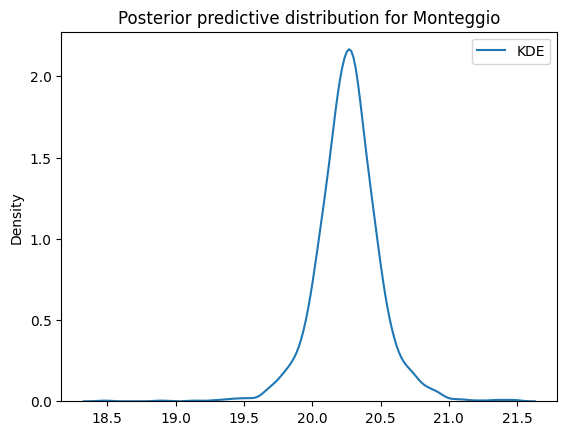

In [103]:
sns.kdeplot(y_new_monteggio, label="KDE")
plt.legend()
plt.title("Posterior predictive distribution for Monteggio");

The posterior predictive distribution for Monteggio shows a sharp peak, indicating a precise estimate of the mean luminance with limited uncertainty.
A plausible point estimate for a new Monteggio observation would be the mean of the distribution above (around 20.26, depending on the run).

## Posterior predictive distribution for a novel group

In [104]:
mu_brill = az.extract_dataset(trace_hier).mu_brill.values
sigma_brill = az.extract_dataset(trace_hier).sigma_brill.values

In [105]:
mu_brill

array([20.2898393 , 19.76091687, 20.07300549, ..., 20.05354656,
       19.65201941, 20.27914995])

In [106]:
mu_loc_new = []
for mu, sigma in zip(mu_brill, sigma_brill):
    mu_loc_new.append(stats.norm.rvs(loc=mu, scale=sigma))

In [107]:
y_new_novel = []

for mu, sigma in zip(mu_loc_new, sigma_loc):
    y_new_novel.append(stats.t.rvs(df=4, loc=mu, scale=sigma))

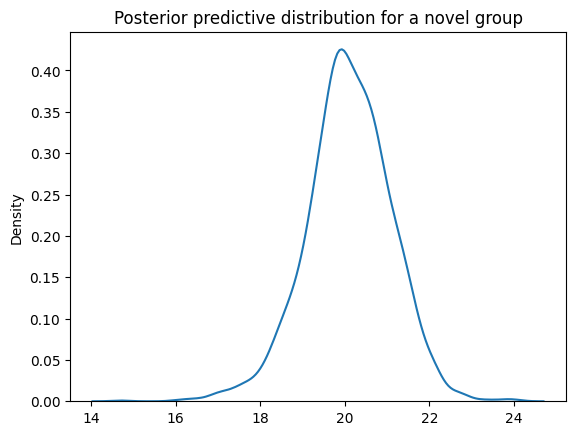

In [108]:
sns.kdeplot(y_new_novel)
plt.title("Posterior predictive distribution for a novel group");

The KDE plot of the posterior predictive distribution for a novel group demonstrates that the hierarchical model can be extended to make predictions for new data points or groups not explicitly covered in the training data. Compared to the posterior predictive distribution computed in the previous task, there is a higher uncertainty, because it considers both the uncertainty of the global luminence distribution and the one of the novel group.